In [62]:
import pandas as pd
import configparser
import numpy as np
from datetime import datetime
import dateutil.relativedelta
from matplotlib import pyplot as plt
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import pickle


from scipy import stats

# Regular expressions
import re

# seaborn : advanced visualization
import seaborn as sns
print('seaborn version\t:',sns.__version__)

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', None) # to display all the columns
pd.set_option('display.max_rows', None) # to display all the columns

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})


from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

seaborn version	: 0.8.1


## DATA PREP FOR JUL-20

In [2]:
## History of CA Agreements of JUL-20
Customer_Hist_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL\CA_HISTORY_JUL_DATA.csv')
Customer_Hist_df.shape
Customer_Hist_df=Customer_Hist_df[Customer_Hist_df.TENOR_COMPLETED=='N']
Customer_Hist_df.shape

(106492, 62)

(67958, 62)

In [4]:
Customer_Hist_df.drop(columns='R',inplace=True)
Customer_Hist_df['YEAR_MONTH'] = [str(i)[3:10] for i in Customer_Hist_df['CUTDATE']]
Customer_Hist_df['YEAR_MONTH'] = pd.to_datetime(Customer_Hist_df.YEAR_MONTH)
Customer_Hist_df = Customer_Hist_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
Customer_Hist_df['PRE_POST_MAR']='BEFORE_MARCH'
Customer_Hist_df.loc[(pd.to_datetime(Customer_Hist_df.AGMT_DATE, format="%d/%m/%Y")> datetime.strptime('01/03/2020',"%d/%m/%Y") ),'PRE_POST_MAR'] ='AFTER_MAR'
Customer_Hist_df['FLOW_FLAG']=np.where(Customer_Hist_df.PAID_COUNT==0,1,0)

In [5]:
## Merging Febuary-19 Profiles to it.
Feb_prof=Customer_Hist_df[(Customer_Hist_df.CUTDATE=='29/02/2020')][['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
Feb_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'FEB_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(Feb_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

(67958, 65)

In [6]:
Customer_Hist_df.drop(index=Customer_Hist_df.index[(Customer_Hist_df.AGMTNO=='AGMTNO')],inplace=True)
Customer_Hist_df_JUL=Customer_Hist_df[Customer_Hist_df.CUTDATE=='31/07/2020']
Customer_Hist_df_JUL.shape


(3887, 65)

In [7]:
## Adding Current month (JUL-20) Profiles to it 
New_prof=Customer_Hist_df_JUL[['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
New_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'NEW_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

Customer_Hist_df_JUL=Customer_Hist_df_JUL.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df_JUL.shape

(67958, 66)

(3887, 66)

## CREATING BOUNCE VARIABLES

In [9]:
Customer_Hist_df.BOUNCE_FLAG.value_counts(dropna=False)


1    37690
0    30268
Name: BOUNCE_FLAG, dtype: int64

In [10]:
## LAST MONTH BOUNCE STATUS
frame_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'BOUNCE_FLAG','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df = frame_comb_df[['AGMTNO', 'YEAR_MONTH', 'CURRENT_DEMAND_STATUS','FLOW_FLAG','OPENING_BUCKET']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df.loc[frame_df.FLOW_FLAG == 1,'DEMAND_BOUNCE_STATUS'] = 'BOU'
lmb_df = frame_df
lmb_df = lmb_df.groupby('AGMTNO').apply(lambda x: x.BOUNCE_FLAG.shift()).to_frame().reset_index().drop(['level_1'], axis = 1)

lmb_df['YEAR_MONTH'] = frame_df['YEAR_MONTH'].tolist()
lmb_df.columns = ['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']
lmb_df['FLOW_FLAG'] = frame_df['FLOW_FLAG'].tolist()
lmb_df[['LAST_MONTH_BOUNCE']]=lmb_df[['LAST_MONTH_BOUNCE']].fillna(0)

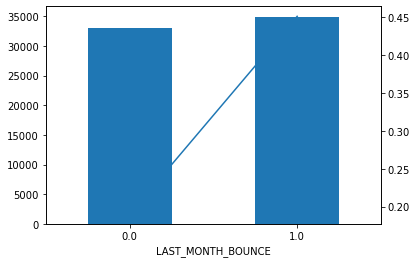

In [11]:
ax = lmb_df.groupby(['LAST_MONTH_BOUNCE']).AGMTNO.count().plot(kind='bar')
lmb_df.groupby(['LAST_MONTH_BOUNCE']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [12]:
## LAST 3 MONTHS  BOUNCE COUNT
l3mb_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mb_df_1 = l3mb_df.copy()
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
#l3mb_df.LAST_MONTH_BOUNCE.astype(int)
l3mb_df = l3mb_df.groupby('AGMTNO')['LAST_MONTH_BOUNCE'].rolling(3, min_periods = 1).sum().to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
l3mb_df['YEAR_MONTH'] = l3mb_df_1['YEAR_MONTH'].tolist()
l3mb_df.columns = ['AGMTNO', 'LAST_3MONTH_BOUNCE_COUNT', 'YEAR_MONTH']

l3mb_df['FLOW_FLAG'] = l3mb_df_1['FLOW_FLAG'].tolist()


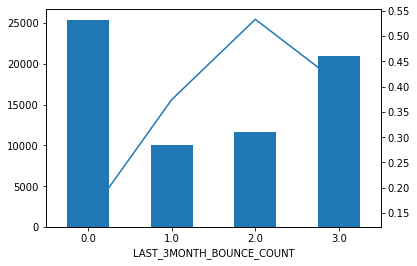

In [13]:
ax = l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).AGMTNO.count().plot(kind='bar')
l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [14]:
##### LONGEST_BOUNCE_STREAK

lbs_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lbs_df_1 = lbs_df.copy()
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
lbs_df = lbs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_BOUNCE * (y.LAST_MONTH_BOUNCE.groupby((y.LAST_MONTH_BOUNCE != y.LAST_MONTH_BOUNCE.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lbs_df.columns = ['AGMTNO', 'LONGEST_BOUNCE_STREAK', 'YEAR_MONTH']

lbs_df['FLOW_FLAG'] = lbs_df_1['FLOW_FLAG'].tolist()
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
#lbs_df = pd.merge(lbs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

In [15]:
# lbs_df.groupby(['LONGEST_BOUNCE_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())
# lbs_df

cut_labels_4 = ['0', '1', '2', '3']
cut_bins = [-1, 0, 1, 2,100]
lbs_df['LBS_BIN']=pd.cut(lbs_df.LONGEST_BOUNCE_STREAK, bins=cut_bins, labels=cut_labels_4)

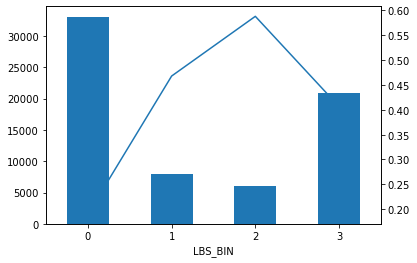

In [16]:
ax = lbs_df.groupby(['LBS_BIN']).AGMTNO.count().plot(kind='bar')
lbs_df.groupby(['LBS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)
# plt.xticks(rotation=90)
# #plt.Figure(10,10)
# # plt.figure(figsize=(10,10)) 

In [17]:
## MERGING BOUNCE FEATURES

bounce_engineered_features_df = l3mb_df

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lbs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_BOUNCE_STREAK']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lmb_df[['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = bounce_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE']]
bounce_engineered_features_df.columns = ['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK','LAST_MONTH_BOUNCE']

bounce_engineered_features_df[['LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK']].fillna(0, inplace = True)
bounce_engineered_features_df[['LAST_MONTH_BOUNCE']].fillna(0, inplace = True)
bounce_engineered_features_df.columns,bounce_engineered_features_df.shape
bounce_engineered_features_df.shape
#bounce_engineered_features_df.to_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv',index=False)

(Index(['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT',
        'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE'],
       dtype='object'), (67958, 5))

(67958, 5)

## OverDue (OD) Related Varaibales

In [18]:
##### HIGHEST_BUCKET

hb_df = Customer_Hist_df[['AGMTNO','YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']]
hb_df = hb_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
hb_df['HIGHEST_BUCKET'] = hb_df.groupby('AGMTNO').OPEN_DPD_BKT_GRP.cummax().shift()

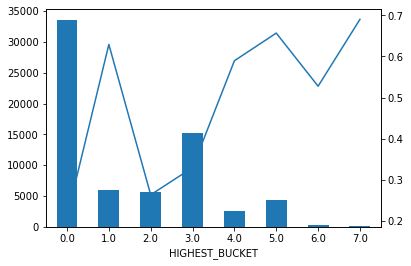

In [19]:
ax = hb_df.groupby(['HIGHEST_BUCKET']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HIGHEST_BUCKET']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [20]:
cut_labels_5 = ['0', '1', '2', '3']
cut_bins = [-1, 0, 1, 2,100]
hb_df['HB_BIN']=pd.cut(hb_df.HIGHEST_BUCKET, bins=cut_bins, labels=cut_labels_5)

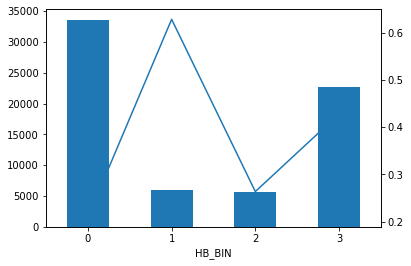

In [21]:
ax = hb_df.groupby(['HB_BIN']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [22]:
## How many times in OD

##### LONGEST_OD_STREAK

los_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
los_df_1 = los_df.copy()
los_df.loc[los_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
los_df.loc[los_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG * (y.OD_CATG.groupby((y.OD_CATG != y.OD_CATG.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
#los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.cumsum().shift()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)

los_df['YEAR_MONTH'] = los_df_1['YEAR_MONTH'].tolist()
#los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
los_df.columns = ['AGMTNO', 'TIMES_IN_OD', 'YEAR_MONTH']
los_df['OPEN_DPD_BKT_GRP'] = los_df_1['OPEN_DPD_BKT_GRP'].tolist()
los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
#los_df=los_df.merge(frame_comb_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
los_df.shape
#los_df['CURRENT_DEMAND_STATUS'] = los_df_1 ['CURRENT_DEMAND_STATUS'].tolist()

(67958, 5)

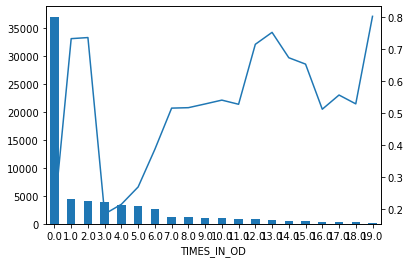

In [24]:
ax = los_df.groupby(['TIMES_IN_OD']).AGMTNO.count().plot(kind='bar')
los_df.groupby(['TIMES_IN_OD']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [25]:
## BINNING TO REMOVE SKEWNESS
cut_labels_5 = ['0', '1', '2', '3','4']
cut_bins = [-1, 0, 1, 2,3,100]
los_df['OD_BIN']=pd.cut(los_df.TIMES_IN_OD, bins=cut_bins, labels=cut_labels_5)

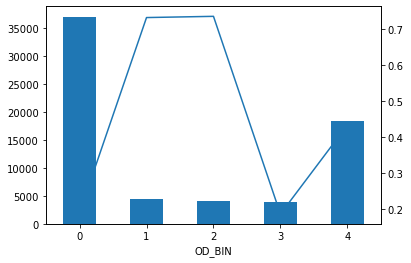

In [26]:
ax = los_df.groupby(['OD_BIN']).AGMTNO.count().plot(kind='bar')
los_df.groupby(['OD_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [29]:
lods_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
                                                                                                                                                                           
lods_df_1 = lods_df.copy()
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
lods_df= lods_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.groupby((y['OD_CATG'] == 0).cumsum().shift()).cumcount()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lods_df['YEAR_MONTH'] = lods_df_1['YEAR_MONTH'].tolist()
#lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
lods_df.columns = ['AGMTNO', 'OD_STREAK', 'YEAR_MONTH']
lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
#lods_df['OPENING_BUCKET'] = lods_df_1 ['OPENING_BUCKET'].tolist()
#lods_df=lods_df.merge(OD_frame_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
lods_df.shape

(67958, 4)

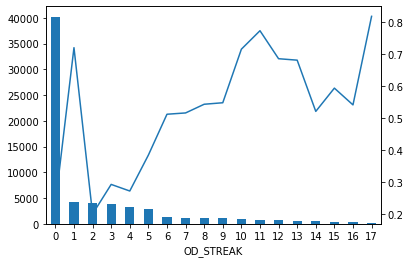

In [30]:
ax = lods_df.groupby(['OD_STREAK']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['OD_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [31]:
## BINING to REMOVE SKEWNESS
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lods_df['ODS_BIN']=pd.cut(lods_df.OD_STREAK, bins=cut_bins, labels=cut_labels_4)

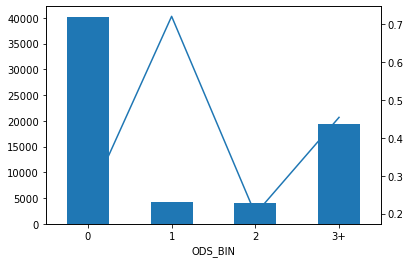

In [32]:
ax = lods_df.groupby(['ODS_BIN']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['ODS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [33]:
OD_engineered_features_df = los_df.copy()

OD_engineered_features_df = pd.merge(OD_engineered_features_df, hb_df[['AGMTNO', 'HB_BIN', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

OD_engineered_features_df = pd.merge(OD_engineered_features_df, lods_df[['AGMTNO', 'YEAR_MONTH', 'ODS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#OD_engineered_features_df.fillna(0, inplace = True)


OD_engineered_features_df = OD_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'HB_BIN','OD_BIN','ODS_BIN']]

OD_engineered_features_df.shape


(67958, 5)

## Bucket MOVEMENT VARIBALES

In [34]:
frame_df=Customer_Hist_df.copy()
frame_df['movement'] = None
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == 0)), 'movement'] = 'normalize'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET < frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'rollback'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'stabilize'

movement = frame_df.groupby(['AGMTNO', 'YEAR_MONTH']).movement.value_counts().unstack().reset_index()
movement.sort_values(by = "YEAR_MONTH", ascending = True, inplace = True)
movement.fillna(0, inplace = True)

#### check for movement columns and add manually if missing 
if('rollback' not in movement.columns):
   movement['rollback'] = 0
   
if('normalize' not in movement.columns):
   movement['normalize'] = 0

if('stabilize' not in movement.columns):
   movement['stabilize']= 0
####

movement_merge = frame_df.merge(movement, how = "left", on = ['AGMTNO', 'YEAR_MONTH'])
movement_merge.sort_values(by = "YEAR_MONTH", inplace = True)

movement_rolling = movement_merge.groupby("AGMTNO")[['normalize', 'rollback', 'stabilize']].transform(lambda x : x.expanding().sum().shift(1))
movement_rolling = movement_rolling.rename(columns = {"normalize": "normalize_total", "rollback": "rollback_total", "stabilize": "stabilize_total"})
movement_rolling = pd.concat([movement_merge, movement_rolling], axis = 1)
movement_rolling = movement_rolling[['AGMTNO', 'YEAR_MONTH', 'normalize_total', 'rollback_total', 'stabilize_total','FLOW_FLAG']].fillna(0)

#movement_rolling .to_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv',index=False)
# # filtering for focus year month
# movement_rolling = movement_rolling.loc[movement_rolling.YEAR_MONTH == focus_year_month, :]


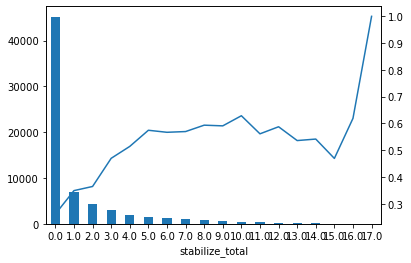

In [35]:
ax = movement_rolling.groupby(['stabilize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['stabilize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [36]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
movement_rolling['STAB_BIN']=pd.cut(movement_rolling.stabilize_total, bins=cut_bins, labels=cut_labels_4)

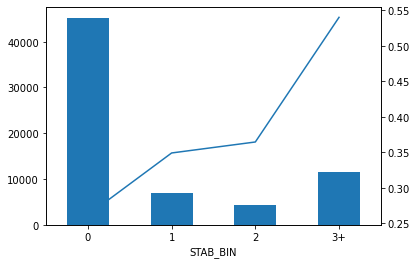

In [37]:
ax = movement_rolling.groupby(['STAB_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['STAB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


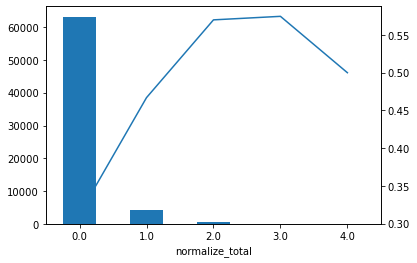

In [38]:
ax = movement_rolling.groupby(['normalize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['normalize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [39]:
cut_labels_4 = ['NOT_NORM', 'NORM']
cut_bins = [-1, 0,100]
movement_rolling['NORM_BIN']=pd.cut(movement_rolling.normalize_total, bins=cut_bins, labels=cut_labels_4)

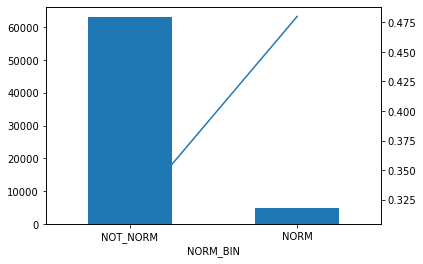

In [40]:
ax = movement_rolling.groupby(['NORM_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['NORM_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [41]:
cut_labels_4 = ['NO', 'YES']
cut_bins = [-1, 0,100]
movement_rolling['RLBK_BIN']=pd.cut(movement_rolling.rollback_total, bins=cut_bins, labels=cut_labels_4)

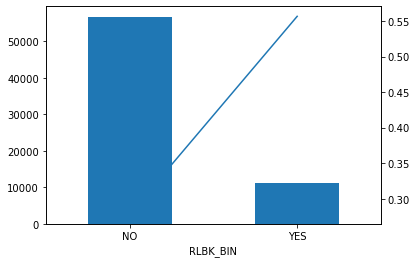

In [42]:
ax = movement_rolling.groupby(['RLBK_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['RLBK_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [43]:
movement_rolling=movement_rolling[['AGMTNO', 'YEAR_MONTH', 'STAB_BIN', 'NORM_BIN','RLBK_BIN']]
movement_rolling.shape

(67958, 5)

## FLOW RELATED VARIABLES

In [44]:
##### LAST MONTH FLOW
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
lmf_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lmf_df_1 = lmf_df.copy()
lmf_df = lmf_df.groupby('AGMTNO').apply(lambda x: x.FLOW_FLAG.shift()).to_frame().reset_index().drop(columns=['level_1'])
lmf_df.columns = ['AGMTNO', 'LAST_MONTH_FLOW']
lmf_df.LAST_MONTH_FLOW.fillna(False, inplace = True)
lmf_df.LAST_MONTH_FLOW = lmf_df.LAST_MONTH_FLOW.fillna(0).astype(int)
lmf_df['YEAR_MONTH'] = lmf_df_1['YEAR_MONTH'].tolist()
lmf_df['FLOW_FLAG'] = lmf_df_1['FLOW_FLAG'].fillna(0).astype(int).tolist()

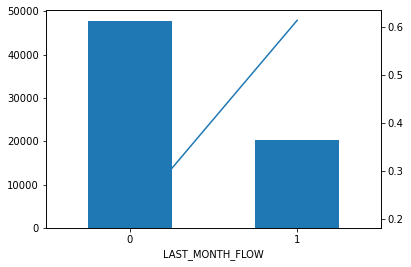

In [45]:
ax = lmf_df.groupby(['LAST_MONTH_FLOW']).AGMTNO.count().plot(kind='bar')
lmf_df.groupby(['LAST_MONTH_FLOW']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [46]:

##### LAST 3 MONTH FLOW COUNT

l3mf_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
l3mf_df_1 = l3mf_df.copy()
l3mf_df = l3mf_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mf_df = l3mf_df.groupby('AGMTNO')['LAST_MONTH_FLOW'].rolling(3, min_periods=1).sum().to_frame().reset_index().drop(['level_1'], axis=1)
l3mf_df.columns = ['AGMTNO', 'LAST_3MONTH_FLOW_COUNT']
l3mf_df['YEAR_MONTH'] = l3mf_df_1['YEAR_MONTH']
l3mf_df['FLOW_FLAG'] = l3mf_df_1['FLOW_FLAG'].tolist()


In [47]:
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())

LAST_3MONTH_FLOW_COUNT
0.00   0.17
1.00   0.43
2.00   0.57
3.00   0.50
dtype: float64

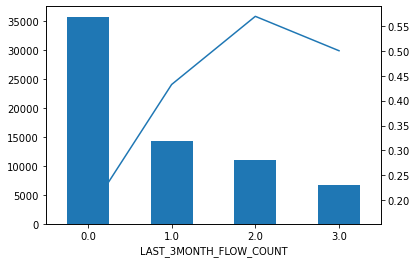

In [48]:
ax = l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).AGMTNO.count().plot(kind='bar')
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [49]:
#### LONGEST FLOW STREAK

lfs_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
lfs_df_1 = lfs_df.copy()
lfs_df = lfs_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
lfs_df = lfs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_FLOW * (y.LAST_MONTH_FLOW.groupby((y.LAST_MONTH_FLOW != y.LAST_MONTH_FLOW.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis=1)
lfs_df.columns = ['AGMTNO', 'LFS']
lfs_df['YEAR_MONTH'] = lfs_df_1['YEAR_MONTH']
lfs_df['LONGEST_FLOW_STREAK'] = lfs_df.groupby('AGMTNO')['LFS'].apply(lambda x : x.expanding().max()).reset_index(drop=True)
lfs_df = lfs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_FLOW_STREAK']]
lfs_df['FLOW_FLAG'] = lfs_df_1['FLOW_FLAG']
# frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
# lfs_df = pd.merge(lfs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')


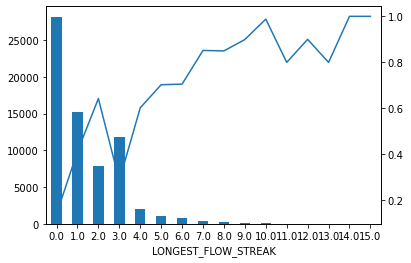

In [50]:
ax = lfs_df.groupby(['LONGEST_FLOW_STREAK']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LONGEST_FLOW_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [51]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lfs_df['LFS_BIN']=pd.cut(lfs_df.LONGEST_FLOW_STREAK, bins=cut_bins, labels=cut_labels_4)

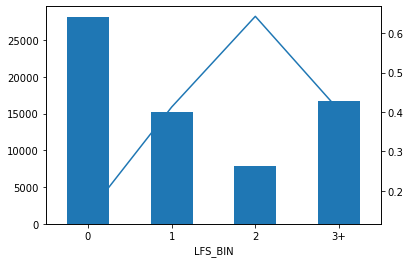

In [52]:
ax = lfs_df.groupby(['LFS_BIN']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LFS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [53]:
## MERGING FLOW FEATURES

flow_engineered_features_df = l3mf_df

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lfs_df[['AGMTNO', 'YEAR_MONTH', 'LFS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lmf_df, on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#flow_engineered_features_df.fillna(0, inplace = True)

flow_engineered_features_df = flow_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW', 'LAST_3MONTH_FLOW_COUNT', 'LFS_BIN']]

flow_engineered_features_df.shape


(67958, 5)

## DEMOGRAPHIC VARIABLES

In [54]:
#Customer_details_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL_CUST_PROFILE_DATA.csv')
Customer_details_df=Customer_Hist_df_JUL[Static_cols]
Customer_details_df.shape


(3887, 37)

In [55]:

Customer_details_df.loc[Customer_details_df.GENDER=='M','GENDER']='MALE'
Customer_details_df.loc[Customer_details_df.GENDER=='F','GENDER']='FEMALE'
Customer_details_df.GENDER.fillna(Customer_details_df.GENDER.value_counts().index[0],inplace=True)
#Customer_details_df.GENDER.value_counts()

Customer_details_df.CIBIL_SCORE.fillna(-1.000, inplace = True)
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE=='LOW_RISK'),'CIBIL_SCORE'] = 750

Customer_details_df['CIBIL_CAT']=None
Customer_details_df['CIBIL_CAT']= np.where((Customer_details_df.CIBIL_SCORE<5),'NEW',np.where(((Customer_details_df.CIBIL_SCORE >=700)& (Customer_details_df.CIBIL_SCORE<=900)),'CREAMY',0))
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=5)& (Customer_details_df.CIBIL_SCORE<=400)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=401)& (Customer_details_df.CIBIL_SCORE<700)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE==-1),'CIBIL_CAT'] = 'NEW'
Customer_details_df.loc[(Customer_details_df.CIBIL_CAT=="0"),'CIBIL_CAT'] = 'NEW'



Master_Cust_Profile = pd.read_csv('D:/Collections/RoF-UC/Master_Profile_Code.csv',encoding='cp1252')
# Master_Model_Code = pd.read_csv('D:/Collections/RoF-UC/Master_Model_Code.csv',encoding='cp1252')

Customer_details_df.CUSTOMER_PROFILE_CODE.fillna(Customer_details_df.CUSTOMER_PROFILE_CODE.value_counts().index[0],inplace=True)
Customer_details_df=Customer_details_df.merge(Master_Cust_Profile[['PROFILE_CODE','PROFILE_GROUP']],left_on='CUSTOMER_PROFILE_CODE'\
                                 ,right_on='PROFILE_CODE',how='left')
Customer_details_df.PROFILE_GROUP.fillna('Others',inplace=True)

# Customer_details_df=Customer_details_df.merge(Master_Model_Code[['MODEL_CODE','MODEL_YEAR','MODEL_SEGMENT']],on='MODEL_CODE',how='left')
# Customer_details_df.MODEL_SEGMENT.fillna(Customer_details_df.MODEL_SEGMENT.value_counts().index[0],inplace=True)


Customer_details_df['LTV_CAT']= np.where((Customer_details_df.LTV>80),'GT80','LT80')

### FOR CA ########################
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10,000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

Customer_details_df.DOWN_PAYMENT.fillna(Customer_details_df.DOWN_PAYMENT.mean(),inplace=True)
cut_labels_5 = ['<=4500', '4501-5500', '5501-6500','6501-7500','7501-10000','10000+']
cut_bins = [-1, 4500, 5500, 6500,7500,10000,1000000]
Customer_details_df['DOWN_PAYMENT_GRP']=pd.cut(Customer_details_df.DOWN_PAYMENT, bins=cut_bins, labels=cut_labels_5)

Customer_details_df.rename(columns={'AREA_DISPALY_NAME':'AREA_NAME','REGIONAL_GROUPING':'REGION'},inplace=True)
Customer_details_df.AREA_NAME.fillna(Customer_details_df.AREA_NAME.value_counts().index[0],inplace=True)

## EMI_CAT
# Customer_details_df['EMI_CAT']=None
# Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-2500'
# #Customer_details_df.loc[Customer_details_df.EMI>=1000,'EMI_CAT']= '1000-2500'
# Customer_details_df.loc[Customer_details_df.EMI>2500,'EMI_CAT']= '2500-5000'
# Customer_details_df.loc[Customer_details_df.EMI> 5000,'EMI_CAT']= 'GT5000'

############ FOR CA #######################

Customer_details_df['EMI_CAT']=None
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

## Customer Profile 
a_p=['Finance related business','Hotel business related','Real estate / Construction related business','Rental Income earner'
    ,'Transport realted business','Pension / Husband income / parental income']
Customer_details_df['FINAL_PROFILE_GRP']=Customer_details_df.PROFILE_GROUP.tolist()
Customer_details_df.loc[Customer_details_df.PROFILE_GROUP.isin(a_p),'FINAL_PROFILE_GRP']='Others'
Customer_details_df.FINAL_PROFILE_GRP.value_counts(dropna=False)

### DIGITAL_SAVVY
#Customer_details_df.DIGITAL_SAVVY_FLAG.fillna(Customer_details_df.DIGITAL_SAVVY_FLAG.value_counts().index[0],inplace=True)

### ADV_EMI_FLAG
Customer_details_df.ADVANCE_EMI_COUNT.fillna(Customer_details_df.ADVANCE_EMI_COUNT.mean(),inplace=True)
Customer_details_df['ADV_EMI_FLAG']=np.where(Customer_details_df.ADVANCE_EMI_COUNT>0,'YES', 'NO')

## POS_TOBE_PAID
Customer_details_df['POS_TOBE_PAID_FINAL']=round((Customer_details_df.POS/Customer_details_df.LOAN_AMOUNT),2)

Customer_details_df.POS_TOBE_PAID_FINAL.fillna(Customer_details_df.POS_TOBE_PAID_FINAL.mean(),inplace=True)
Customer_details_df.loc[Customer_details_df.POS_TOBE_PAID_FINAL >1, 'POS_TOBE_PAID_FINAL']=1


# final_vars=[ 'AGMTNO','DIGITAL_SAVVY_FLAG', 'ROF_SEGMENT','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL'
#             ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df.FEB_COLLECTIONS_SEGMENTS.fillna(Customer_details_df.FEB_COLLECTIONS_SEGMENTS.value_counts().index[0],inplace=True)
final_vars=[ 'AGMTNO','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL','FEB_COLLECTIONS_SEGMENTS','NEW_COLLECTIONS_SEGMENTS'
            ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df[final_vars].isnull().sum()


Self employed with business premisis    1526
Others                                  1009
Salaried employee                        644
Agriculture related business             411
Self employed - professional             256
Caution Profile                           41
Name: FINAL_PROFILE_GRP, dtype: int64

AGMTNO                      0
ADV_EMI_FLAG                0
GENDER                      0
POS_TOBE_PAID_FINAL         0
FEB_COLLECTIONS_SEGMENTS    0
NEW_COLLECTIONS_SEGMENTS    0
CIBIL_CAT                   0
PROFILE_CODE                0
PROFILE_GROUP               0
LTV_CAT                     0
EMI_CAT                     0
DOWN_PAYMENT_GRP            0
FINAL_PROFILE_GRP           0
dtype: int64

## EDA on DEMO Variables

In [56]:
Rest_cols=set(Customer_Hist_df.columns.to_list()) - set(Static_cols)
Rest_cols.add('AGMTNO')
Rest_cols= list(Rest_cols)
#Rest_cols

In [57]:
Cust_Final_df=pd.DataFrame()
Cust_Final_df=pd.merge(Customer_Hist_df[Rest_cols],Customer_details_df,on='AGMTNO',how='inner')
Cust_Final_df.shape


(66571, 75)

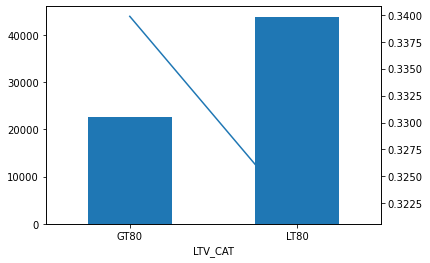

In [58]:
## LTV
ax = Cust_Final_df.groupby(['LTV_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['LTV_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [59]:
# ## ROF
# ax = Cust_Final_df.groupby(['ROF_SEGMENT']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['ROF_SEGMENT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

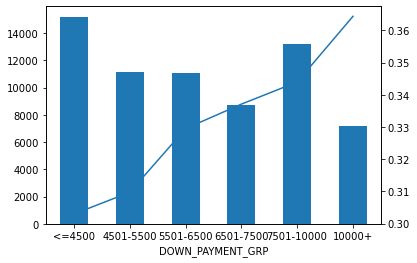

In [60]:
## DOWN_PAYMENT_GRP
ax = Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

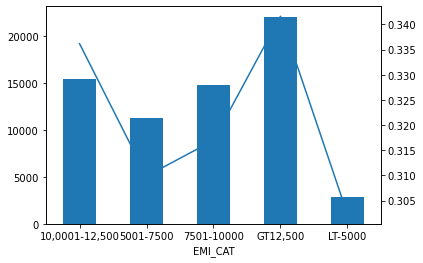

In [61]:
## EMI_CAT

ax = Cust_Final_df.groupby(['EMI_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['EMI_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

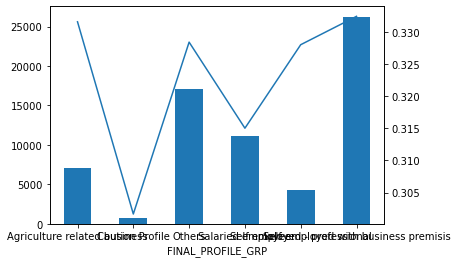

In [62]:
ax = Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


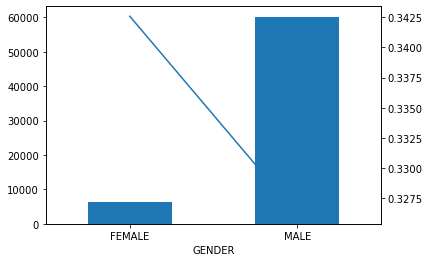

In [63]:
### GENDER
ax = Cust_Final_df.groupby(['GENDER']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['GENDER']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [64]:
# ### DIGITAL_SAVVY
# ax = Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


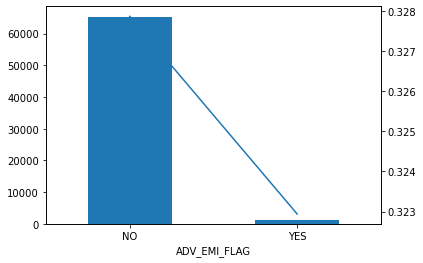

In [65]:
### ADV_EMI_FLAG

ax = Cust_Final_df.groupby(['ADV_EMI_FLAG']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['ADV_EMI_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


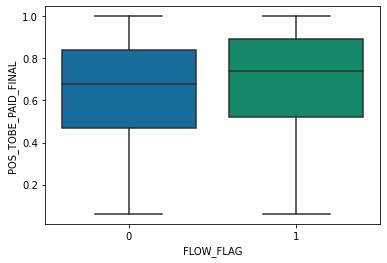

In [66]:
## POS_TOBE_PAID
sns.boxplot(x='FLOW_FLAG',y='POS_TOBE_PAID_FINAL', 
                 data=Cust_Final_df,
                 palette="colorblind"
                 )

## FINAL DATA PREPARATION

In [67]:
complete_df_JUL=Customer_details_df[final_vars].copy()
complete_df_JUL.shape

# bounce_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv')
# bounce_features['YEAR_MONTH'] = pd.to_datetime(bounce_features.YEAR_MONTH,format='%d/%m/%Y')
complete_df_JUL = complete_df_JUL.merge(bounce_engineered_features_df, on = ['AGMTNO'], how = "left")
del bounce_features
print(complete_df_JUL.shape)

# flow_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/flow_engineered_features.csv')
# flow_features['YEAR_MONTH'] = pd.to_datetime(flow_features.YEAR_MONTH)
complete_df_JUL = complete_df_JUL.merge(flow_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
del flow_features
print(complete_df_JUL.shape)


#OD_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/OD_engineered_features.csv')
#OD_features['YEAR_MONTH'] = pd.to_datetime(OD_features.YEAR_MONTH)
complete_df_JUL = complete_df_JUL.merge(OD_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_JUL.shape)

#movement_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv')
#movement_features['YEAR_MONTH'] = pd.to_datetime(movement_features.YEAR_MONTH)
complete_df_JUL = complete_df_JUL.merge(movement_rolling, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
del movement_features
complete_df_JUL = complete_df_JUL.merge(Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','FLOW_FLAG']], on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_JUL.shape)


(3887, 13)

(66571, 17)
(66571, 20)
(66571, 23)
(66571, 27)


In [69]:
## ADDING Moratorium related variables
MORAT_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL\CA_MORAT_JUL_OCT_DATA.csv')
MORAT_df.shape
complete_df_JUL=complete_df_JUL.merge(MORAT_df,on='AGMTNO',how='left')
complete_df_JUL.MORAT_FLAG.fillna('NO_MORAT',inplace=True)
complete_df_JUL.loc[complete_df_JUL.MORAT_FLAG=='SuoMoto ,Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_JUL.loc[complete_df_JUL.MORAT_FLAG=='SuoMoto ','MORAT_FLAG']='SuoMoto'
complete_df_JUL.loc[complete_df_JUL.MORAT_FLAG=='Gen_Morat','MORAT_FLAG']='Gen_Morat'
complete_df_JUL.MORAT_FLAG.value_counts(dropna=False)
complete_df_JUL.drop(columns={'MORAT_MONTH'},inplace=True)
complete_df_JUL.shape

(25312, 3)

NO_MORAT    40920
SuoMoto     25651
Name: MORAT_FLAG, dtype: int64

(66571, 28)

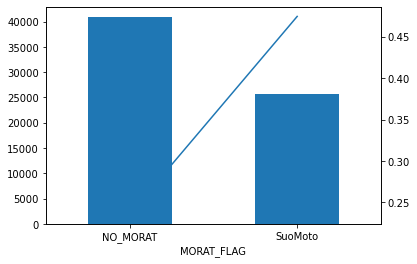

In [70]:
ax = complete_df_JUL.groupby(['MORAT_FLAG']).AGMTNO.count().plot(kind='bar')
complete_df_JUL.groupby(['MORAT_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [71]:
## MISISNG VALUE TREATMENT

complete_df_JUL.isna().sum()
complete_df_JUL.HB_BIN.fillna(complete_df_JUL.HB_BIN.value_counts().index[0],inplace=True)

complete_df_JUL.isna().values.sum()

AGMTNO                      0
ADV_EMI_FLAG                0
GENDER                      0
POS_TOBE_PAID_FINAL         0
FEB_COLLECTIONS_SEGMENTS    0
NEW_COLLECTIONS_SEGMENTS    0
CIBIL_CAT                   0
PROFILE_CODE                0
PROFILE_GROUP               0
LTV_CAT                     0
EMI_CAT                     0
DOWN_PAYMENT_GRP            0
FINAL_PROFILE_GRP           0
YEAR_MONTH                  0
LAST_3MONTH_BOUNCE_COUNT    0
LONGEST_BOUNCE_STREAK       0
LAST_MONTH_BOUNCE           0
LAST_MONTH_FLOW             0
LAST_3MONTH_FLOW_COUNT      0
LFS_BIN                     0
HB_BIN                      1
OD_BIN                      0
ODS_BIN                     0
STAB_BIN                    0
NORM_BIN                    0
RLBK_BIN                    0
FLOW_FLAG                   0
MORAT_FLAG                  0
dtype: int64

0

## DATA PREP FOR AUG-20

In [73]:
## History of CA Agreements of AUG-20
Customer_Hist_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL\CA_HISTORY_AUG_DATA.csv')
Customer_Hist_df.shape
Customer_Hist_df=Customer_Hist_df[Customer_Hist_df.TENOR_COMPLETED=='N']
Customer_Hist_df.shape

(121428, 62)

(78287, 62)

In [74]:
Customer_Hist_df.drop(columns='R',inplace=True)
Customer_Hist_df['YEAR_MONTH'] = [str(i)[3:10] for i in Customer_Hist_df['CUTDATE']]
Customer_Hist_df['YEAR_MONTH'] = pd.to_datetime(Customer_Hist_df.YEAR_MONTH)
Customer_Hist_df = Customer_Hist_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
Customer_Hist_df['PRE_POST_MAR']='BEFORE_MARCH'
Customer_Hist_df.loc[(pd.to_datetime(Customer_Hist_df.AGMT_DATE, format="%d/%m/%Y")> datetime.strptime('01/03/2020',"%d/%m/%Y") ),'PRE_POST_MAR'] ='AFTER_MAR'
Customer_Hist_df['FLOW_FLAG']=np.where(Customer_Hist_df.PAID_COUNT==0,1,0)

In [75]:
Feb_prof=Customer_Hist_df[(Customer_Hist_df.CUTDATE=='29/02/2020')][['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
Feb_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'FEB_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(Feb_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

(78287, 65)

In [76]:
Customer_Hist_df.drop(index=Customer_Hist_df.index[(Customer_Hist_df.AGMTNO=='AGMTNO')],inplace=True)
Customer_Hist_df_AUG=Customer_Hist_df[Customer_Hist_df.CUTDATE=='31/08/2020']
Customer_Hist_df_AUG.shape


(4485, 65)

In [77]:
New_prof=Customer_Hist_df_AUG[['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
New_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'NEW_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

Customer_Hist_df_AUG=Customer_Hist_df_AUG.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df_AUG.shape

(78287, 66)

(4485, 66)

## CREATING BOUNCE VARIABLES

In [79]:
Customer_Hist_df.BOUNCE_FLAG.value_counts(dropna=False)


1    43670
0    34617
Name: BOUNCE_FLAG, dtype: int64

In [80]:
## LAST MONTH BOUNCE
frame_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'BOUNCE_FLAG','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df = frame_comb_df[['AGMTNO', 'YEAR_MONTH', 'CURRENT_DEMAND_STATUS','FLOW_FLAG','OPENING_BUCKET']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df.loc[frame_df.FLOW_FLAG == 1,'DEMAND_BOUNCE_STATUS'] = 'BOU'
lmb_df = frame_df
lmb_df = lmb_df.groupby('AGMTNO').apply(lambda x: x.BOUNCE_FLAG.shift()).to_frame().reset_index().drop(['level_1'], axis = 1)

lmb_df['YEAR_MONTH'] = frame_df['YEAR_MONTH'].tolist()
lmb_df.columns = ['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']
lmb_df['FLOW_FLAG'] = frame_df['FLOW_FLAG'].tolist()
lmb_df[['LAST_MONTH_BOUNCE']]=lmb_df[['LAST_MONTH_BOUNCE']].fillna(0)

In [81]:
##  LAST 3 MONTH BOUNCE COUNT
l3mb_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mb_df_1 = l3mb_df.copy()
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
#l3mb_df.LAST_MONTH_BOUNCE.astype(int)
l3mb_df = l3mb_df.groupby('AGMTNO')['LAST_MONTH_BOUNCE'].rolling(3, min_periods = 1).sum().to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
l3mb_df['YEAR_MONTH'] = l3mb_df_1['YEAR_MONTH'].tolist()
l3mb_df.columns = ['AGMTNO', 'LAST_3MONTH_BOUNCE_COUNT', 'YEAR_MONTH']

l3mb_df['FLOW_FLAG'] = l3mb_df_1['FLOW_FLAG'].tolist()


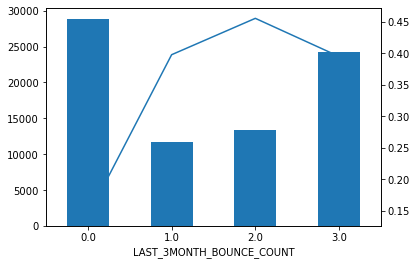

In [82]:
ax = l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).AGMTNO.count().plot(kind='bar')
l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [83]:
##### LONGEST_BOUNCE_STREAK

lbs_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lbs_df_1 = lbs_df.copy()
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
lbs_df = lbs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_BOUNCE * (y.LAST_MONTH_BOUNCE.groupby((y.LAST_MONTH_BOUNCE != y.LAST_MONTH_BOUNCE.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lbs_df.columns = ['AGMTNO', 'LONGEST_BOUNCE_STREAK', 'YEAR_MONTH']

lbs_df['FLOW_FLAG'] = lbs_df_1['FLOW_FLAG'].tolist()
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
#lbs_df = pd.merge(lbs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

In [84]:
cut_labels_4 = ['0', '1', '2', '3','4+']
cut_bins = [-1, 0, 1, 2,3,100]
lbs_df['LBS_BIN']=pd.cut(lbs_df.LONGEST_BOUNCE_STREAK, bins=cut_bins, labels=cut_labels_4)

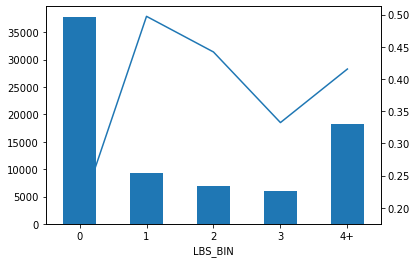

In [85]:
ax = lbs_df.groupby(['LBS_BIN']).AGMTNO.count().plot(kind='bar')
lbs_df.groupby(['LBS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)
# plt.xticks(rotation=90)
# #plt.Figure(10,10)
# # plt.figure(figsize=(10,10)) 

In [86]:
## MERGING BOUNCE FEATURES

bounce_engineered_features_df = l3mb_df

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lbs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_BOUNCE_STREAK']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lmb_df[['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = bounce_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE']]
bounce_engineered_features_df.columns = ['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK','LAST_MONTH_BOUNCE']

bounce_engineered_features_df[['LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK']].fillna(0, inplace = True)
bounce_engineered_features_df[['LAST_MONTH_BOUNCE']].fillna(0, inplace = True)
bounce_engineered_features_df.columns,bounce_engineered_features_df.shape
bounce_engineered_features_df.shape
#bounce_engineered_features_df.to_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv',index=False)

(Index(['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT',
        'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE'],
       dtype='object'), (78287, 5))

(78287, 5)

## OD Related Varaibales

In [87]:
##### HIGHEST_BUCKET

hb_df = Customer_Hist_df[['AGMTNO','YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']]
hb_df = hb_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
hb_df['HIGHEST_BUCKET'] = hb_df.groupby('AGMTNO').OPEN_DPD_BKT_GRP.cummax().shift()

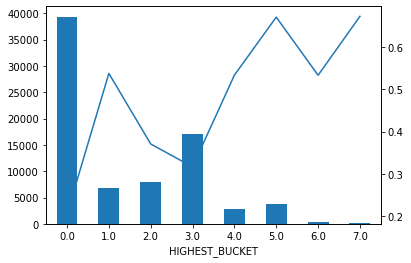

In [88]:
ax = hb_df.groupby(['HIGHEST_BUCKET']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HIGHEST_BUCKET']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [89]:
cut_labels_5 = ['0', '1', '2', '3','4','5+']
cut_bins = [-1, 0, 1, 2,3,4,100]
hb_df['HB_BIN']=pd.cut(hb_df.HIGHEST_BUCKET, bins=cut_bins, labels=cut_labels_5)

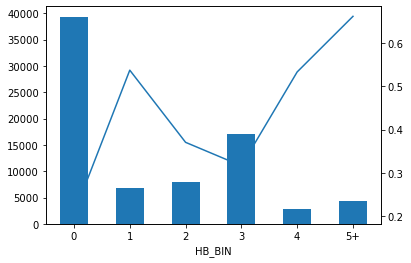

In [90]:
ax = hb_df.groupby(['HB_BIN']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [91]:
## How many times in OD

los_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
los_df_1 = los_df.copy()
los_df.loc[los_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
los_df.loc[los_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
#los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG * (y.OD_CATG.groupby((y.OD_CATG != y.OD_CATG.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.cumsum().shift()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)

los_df['YEAR_MONTH'] = los_df_1['YEAR_MONTH'].tolist()
#los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
los_df.columns = ['AGMTNO', 'TIMES_IN_OD', 'YEAR_MONTH']
los_df['OPEN_DPD_BKT_GRP'] = los_df_1['OPEN_DPD_BKT_GRP'].tolist()
los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
#los_df=los_df.merge(frame_comb_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
los_df.shape
#los_df['CURRENT_DEMAND_STATUS'] = los_df_1 ['CURRENT_DEMAND_STATUS'].tolist()

(78287, 5)

In [92]:
los_df['OD_BIN']=np.where(los_df.TIMES_IN_OD>0, 'NO', 'YES')

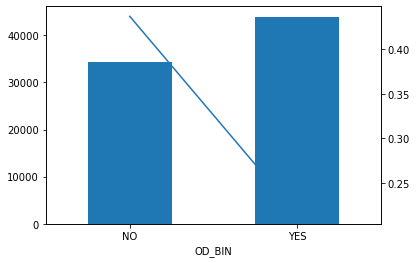

In [93]:
ax = los_df.groupby(['OD_BIN']).AGMTNO.count().plot(kind='bar')
los_df.groupby(['OD_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [94]:
lods_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
                                                                                                                                                                           
lods_df_1 = lods_df.copy()
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
lods_df= lods_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.groupby((y['OD_CATG'] == 0).cumsum().shift()).cumcount()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lods_df['YEAR_MONTH'] = lods_df_1['YEAR_MONTH'].tolist()
#lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
lods_df.columns = ['AGMTNO', 'OD_STREAK', 'YEAR_MONTH']
lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
#lods_df['OPENING_BUCKET'] = lods_df_1 ['OPENING_BUCKET'].tolist()
#lods_df=lods_df.merge(OD_frame_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
lods_df.shape

(78287, 4)

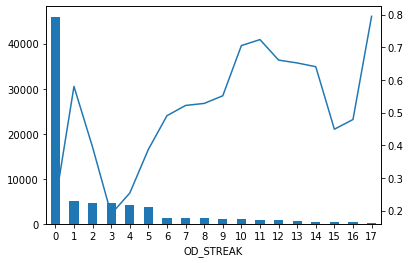

In [95]:
ax = lods_df.groupby(['OD_STREAK']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['OD_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [96]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lods_df['ODS_BIN']=pd.cut(lods_df.OD_STREAK, bins=cut_bins, labels=cut_labels_4)

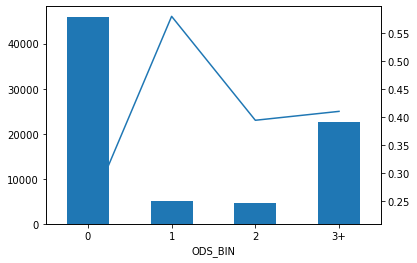

In [97]:
ax = lods_df.groupby(['ODS_BIN']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['ODS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [98]:
OD_engineered_features_df = los_df.copy()

OD_engineered_features_df = pd.merge(OD_engineered_features_df, hb_df[['AGMTNO', 'HB_BIN', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

OD_engineered_features_df = pd.merge(OD_engineered_features_df, lods_df[['AGMTNO', 'YEAR_MONTH', 'ODS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#OD_engineered_features_df.fillna(0, inplace = True)


OD_engineered_features_df = OD_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'HB_BIN','OD_BIN','ODS_BIN']]

OD_engineered_features_df.shape


(78287, 5)

## MOVEMENT VARIBALES

In [99]:
frame_df=Customer_Hist_df.copy()
frame_df['movement'] = None
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == 0)), 'movement'] = 'normalize'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET < frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'rollback'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'stabilize'

movement = frame_df.groupby(['AGMTNO', 'YEAR_MONTH']).movement.value_counts().unstack().reset_index()
movement.sort_values(by = "YEAR_MONTH", ascending = True, inplace = True)
movement.fillna(0, inplace = True)

#### check for movement columns and add manually if missing 
if('rollback' not in movement.columns):
   movement['rollback'] = 0
   
if('normalize' not in movement.columns):
   movement['normalize'] = 0

if('stabilize' not in movement.columns):
   movement['stabilize']= 0
####

movement_merge = frame_df.merge(movement, how = "left", on = ['AGMTNO', 'YEAR_MONTH'])
movement_merge.sort_values(by = "YEAR_MONTH", inplace = True)

movement_rolling = movement_merge.groupby("AGMTNO")[['normalize', 'rollback', 'stabilize']].transform(lambda x : x.expanding().sum().shift(1))
movement_rolling = movement_rolling.rename(columns = {"normalize": "normalize_total", "rollback": "rollback_total", "stabilize": "stabilize_total"})
movement_rolling = pd.concat([movement_merge, movement_rolling], axis = 1)
movement_rolling = movement_rolling[['AGMTNO', 'YEAR_MONTH', 'normalize_total', 'rollback_total', 'stabilize_total','FLOW_FLAG']].fillna(0)

#movement_rolling .to_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv',index=False)
# # filtering for focus year month
# movement_rolling = movement_rolling.loc[movement_rolling.YEAR_MONTH == focus_year_month, :]


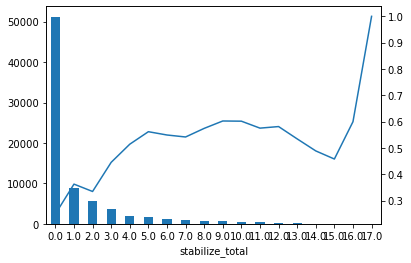

In [100]:
ax = movement_rolling.groupby(['stabilize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['stabilize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [101]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
movement_rolling['STAB_BIN']=pd.cut(movement_rolling.stabilize_total, bins=cut_bins, labels=cut_labels_4)

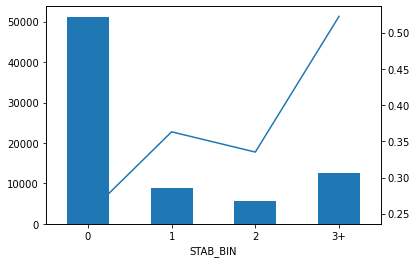

In [102]:
ax = movement_rolling.groupby(['STAB_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['STAB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


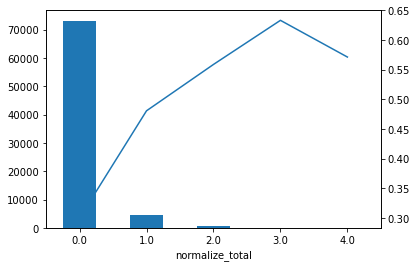

In [103]:
ax = movement_rolling.groupby(['normalize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['normalize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [104]:
cut_labels_4 = ['NOT_NORM', 'NORM']
cut_bins = [-1, 0,100]
movement_rolling['NORM_BIN']=pd.cut(movement_rolling.normalize_total, bins=cut_bins, labels=cut_labels_4)

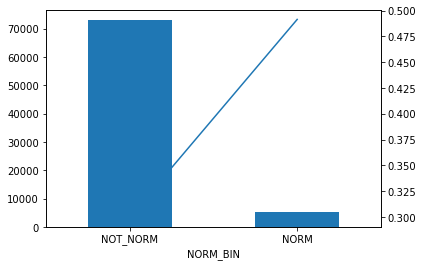

In [105]:
ax = movement_rolling.groupby(['NORM_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['NORM_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [106]:
cut_labels_4 = ['NO', 'YES']
cut_bins = [-1, 0,100]
movement_rolling['RLBK_BIN']=pd.cut(movement_rolling.rollback_total, bins=cut_bins, labels=cut_labels_4)

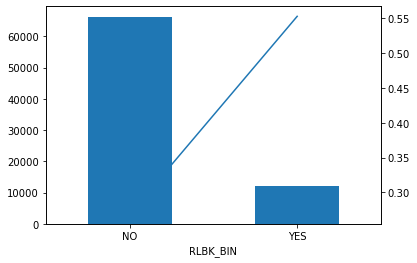

In [107]:
ax = movement_rolling.groupby(['RLBK_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['RLBK_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [108]:
movement_rolling=movement_rolling[['AGMTNO', 'YEAR_MONTH', 'STAB_BIN', 'NORM_BIN','RLBK_BIN']]
movement_rolling.shape

(78287, 5)

## FLOW VARIABLES

In [109]:
##### LAST MONTH FLOW
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
lmf_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lmf_df_1 = lmf_df.copy()
lmf_df = lmf_df.groupby('AGMTNO').apply(lambda x: x.FLOW_FLAG.shift()).to_frame().reset_index().drop(columns=['level_1'])
lmf_df.columns = ['AGMTNO', 'LAST_MONTH_FLOW']
lmf_df.LAST_MONTH_FLOW.fillna(False, inplace = True)
lmf_df.LAST_MONTH_FLOW = lmf_df.LAST_MONTH_FLOW.fillna(0).astype(int)
lmf_df['YEAR_MONTH'] = lmf_df_1['YEAR_MONTH'].tolist()
lmf_df['FLOW_FLAG'] = lmf_df_1['FLOW_FLAG'].fillna(0).astype(int).tolist()

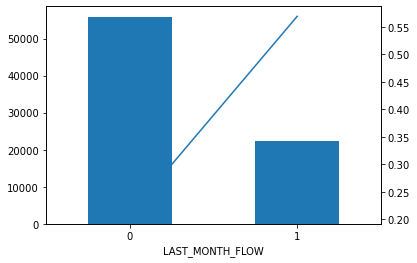

In [110]:
ax = lmf_df.groupby(['LAST_MONTH_FLOW']).AGMTNO.count().plot(kind='bar')
lmf_df.groupby(['LAST_MONTH_FLOW']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [111]:

##### LAST 3 MONTH FLOW COUNT

l3mf_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
l3mf_df_1 = l3mf_df.copy()
l3mf_df = l3mf_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mf_df = l3mf_df.groupby('AGMTNO')['LAST_MONTH_FLOW'].rolling(3, min_periods=1).sum().to_frame().reset_index().drop(['level_1'], axis=1)
l3mf_df.columns = ['AGMTNO', 'LAST_3MONTH_FLOW_COUNT']
l3mf_df['YEAR_MONTH'] = l3mf_df_1['YEAR_MONTH']
l3mf_df['FLOW_FLAG'] = l3mf_df_1['FLOW_FLAG'].tolist()


In [112]:
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())

LAST_3MONTH_FLOW_COUNT
0.00   0.17
1.00   0.42
2.00   0.50
3.00   0.55
dtype: float64

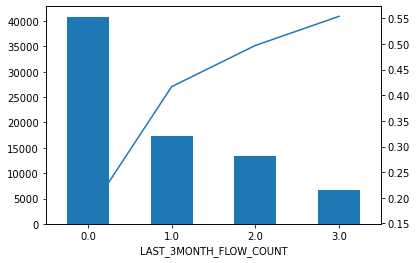

In [113]:
ax = l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).AGMTNO.count().plot(kind='bar')
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [114]:
#### LONGEST FLOW STREAK

lfs_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
lfs_df_1 = lfs_df.copy()
lfs_df = lfs_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
lfs_df = lfs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_FLOW * (y.LAST_MONTH_FLOW.groupby((y.LAST_MONTH_FLOW != y.LAST_MONTH_FLOW.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis=1)
lfs_df.columns = ['AGMTNO', 'LFS']
lfs_df['YEAR_MONTH'] = lfs_df_1['YEAR_MONTH']
lfs_df['LONGEST_FLOW_STREAK'] = lfs_df.groupby('AGMTNO')['LFS'].apply(lambda x : x.expanding().max()).reset_index(drop=True)
lfs_df = lfs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_FLOW_STREAK']]
lfs_df['FLOW_FLAG'] = lfs_df_1['FLOW_FLAG']
# frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
# lfs_df = pd.merge(lfs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')


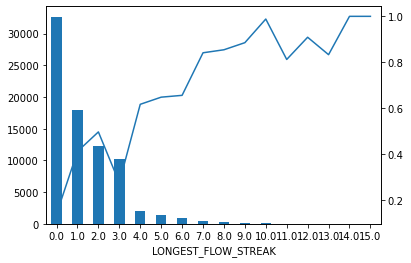

In [115]:
ax = lfs_df.groupby(['LONGEST_FLOW_STREAK']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LONGEST_FLOW_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [116]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lfs_df['LFS_BIN']=pd.cut(lfs_df.LONGEST_FLOW_STREAK, bins=cut_bins, labels=cut_labels_4)

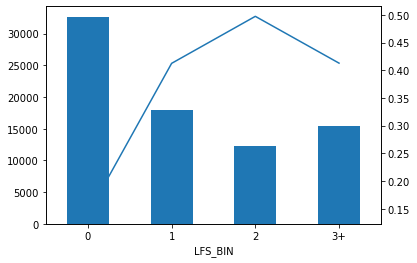

In [117]:
ax = lfs_df.groupby(['LFS_BIN']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LFS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [118]:
## MERGING FLOW FEATURES

flow_engineered_features_df = l3mf_df

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lfs_df[['AGMTNO', 'YEAR_MONTH', 'LFS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lmf_df, on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#flow_engineered_features_df.fillna(0, inplace = True)

flow_engineered_features_df = flow_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW', 'LAST_3MONTH_FLOW_COUNT', 'LFS_BIN']]

flow_engineered_features_df.shape


(78287, 5)

## DEMOGRAPHIC VARIABLES

In [119]:
#Customer_details_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL_CUST_PROFILE_DATA.csv')
Customer_details_df=Customer_Hist_df_AUG[Static_cols]
Customer_details_df.shape


(4485, 37)

In [120]:

Customer_details_df.loc[Customer_details_df.GENDER=='M','GENDER']='MALE'
Customer_details_df.loc[Customer_details_df.GENDER=='F','GENDER']='FEMALE'
Customer_details_df.GENDER.fillna(Customer_details_df.GENDER.value_counts().index[0],inplace=True)
#Customer_details_df.GENDER.value_counts()

Customer_details_df.CIBIL_SCORE.fillna(-1.000, inplace = True)
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE=='LOW_RISK'),'CIBIL_SCORE'] = 750

Customer_details_df['CIBIL_CAT']=None
Customer_details_df['CIBIL_CAT']= np.where((Customer_details_df.CIBIL_SCORE<5),'NEW',np.where(((Customer_details_df.CIBIL_SCORE >=700)& (Customer_details_df.CIBIL_SCORE<=900)),'CREAMY',0))
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=5)& (Customer_details_df.CIBIL_SCORE<=400)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=401)& (Customer_details_df.CIBIL_SCORE<700)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE==-1),'CIBIL_CAT'] = 'NEW'
Customer_details_df.loc[(Customer_details_df.CIBIL_CAT=="0"),'CIBIL_CAT'] = 'NEW'



Master_Cust_Profile = pd.read_csv('D:/Collections/RoF-UC/Master_Profile_Code.csv',encoding='cp1252')
# Master_Model_Code = pd.read_csv('D:/Collections/RoF-UC/Master_Model_Code.csv',encoding='cp1252')

Customer_details_df.CUSTOMER_PROFILE_CODE.fillna(Customer_details_df.CUSTOMER_PROFILE_CODE.value_counts().index[0],inplace=True)
Customer_details_df=Customer_details_df.merge(Master_Cust_Profile[['PROFILE_CODE','PROFILE_GROUP']],left_on='CUSTOMER_PROFILE_CODE'\
                                 ,right_on='PROFILE_CODE',how='left')
Customer_details_df.PROFILE_GROUP.fillna('Others',inplace=True)

# Customer_details_df=Customer_details_df.merge(Master_Model_Code[['MODEL_CODE','MODEL_YEAR','MODEL_SEGMENT']],on='MODEL_CODE',how='left')
# Customer_details_df.MODEL_SEGMENT.fillna(Customer_details_df.MODEL_SEGMENT.value_counts().index[0],inplace=True)


Customer_details_df['LTV_CAT']= np.where((Customer_details_df.LTV>80),'GT80','LT80')

### FOR CA ########################
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10,000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

Customer_details_df.DOWN_PAYMENT.fillna(Customer_details_df.DOWN_PAYMENT.mean(),inplace=True)
cut_labels_5 = ['<=4500', '4501-5500', '5501-6500','6501-7500','7501-10000','10000+']
cut_bins = [-1, 4500, 5500, 6500,7500,10000,1000000]
Customer_details_df['DOWN_PAYMENT_GRP']=pd.cut(Customer_details_df.DOWN_PAYMENT, bins=cut_bins, labels=cut_labels_5)

Customer_details_df.rename(columns={'AREA_DISPALY_NAME':'AREA_NAME','REGIONAL_GROUPING':'REGION'},inplace=True)
Customer_details_df.AREA_NAME.fillna(Customer_details_df.AREA_NAME.value_counts().index[0],inplace=True)

## EMI_CAT
# Customer_details_df['EMI_CAT']=None
# Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-2500'
# #Customer_details_df.loc[Customer_details_df.EMI>=1000,'EMI_CAT']= '1000-2500'
# Customer_details_df.loc[Customer_details_df.EMI>2500,'EMI_CAT']= '2500-5000'
# Customer_details_df.loc[Customer_details_df.EMI> 5000,'EMI_CAT']= 'GT5000'

############ FOR CA #######################

Customer_details_df['EMI_CAT']=None
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

## Customer Profile 
a_p=['Finance related business','Hotel business related','Real estate / Construction related business','Rental Income earner'
    ,'Transport realted business','Pension / Husband income / parental income']
Customer_details_df['FINAL_PROFILE_GRP']=Customer_details_df.PROFILE_GROUP.tolist()
Customer_details_df.loc[Customer_details_df.PROFILE_GROUP.isin(a_p),'FINAL_PROFILE_GRP']='Others'
Customer_details_df.FINAL_PROFILE_GRP.value_counts(dropna=False)

### DIGITAL_SAVVY
#Customer_details_df.DIGITAL_SAVVY_FLAG.fillna(Customer_details_df.DIGITAL_SAVVY_FLAG.value_counts().index[0],inplace=True)

### ADV_EMI_FLAG
Customer_details_df.ADVANCE_EMI_COUNT.fillna(Customer_details_df.ADVANCE_EMI_COUNT.mean(),inplace=True)
Customer_details_df['ADV_EMI_FLAG']=np.where(Customer_details_df.ADVANCE_EMI_COUNT>0,'YES', 'NO')

## POS_TOBE_PAID
Customer_details_df['POS_TOBE_PAID_FINAL']=round((Customer_details_df.POS/Customer_details_df.LOAN_AMOUNT),2)

Customer_details_df.POS_TOBE_PAID_FINAL.fillna(Customer_details_df.POS_TOBE_PAID_FINAL.mean(),inplace=True)
Customer_details_df.loc[Customer_details_df.POS_TOBE_PAID_FINAL >1, 'POS_TOBE_PAID_FINAL']=1


# final_vars=[ 'AGMTNO','DIGITAL_SAVVY_FLAG', 'ROF_SEGMENT','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL'
#             ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df.FEB_COLLECTIONS_SEGMENTS.fillna(Customer_details_df.FEB_COLLECTIONS_SEGMENTS.value_counts().index[0],inplace=True)
final_vars=[ 'AGMTNO','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL','FEB_COLLECTIONS_SEGMENTS','NEW_COLLECTIONS_SEGMENTS'
            ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df[final_vars].isnull().sum()


Self employed with business premisis    1748
Others                                  1195
Salaried employee                        739
Agriculture related business             444
Self employed - professional             317
Caution Profile                           42
Name: FINAL_PROFILE_GRP, dtype: int64

AGMTNO                      0
ADV_EMI_FLAG                0
GENDER                      0
POS_TOBE_PAID_FINAL         0
FEB_COLLECTIONS_SEGMENTS    0
NEW_COLLECTIONS_SEGMENTS    0
CIBIL_CAT                   0
PROFILE_CODE                0
PROFILE_GROUP               0
LTV_CAT                     0
EMI_CAT                     0
DOWN_PAYMENT_GRP            0
FINAL_PROFILE_GRP           0
dtype: int64

## EDA on DEMO Variables

In [121]:
Rest_cols=set(Customer_Hist_df.columns.to_list()) - set(Static_cols)
Rest_cols.add('AGMTNO')
Rest_cols= list(Rest_cols)
#Rest_cols

In [122]:
Cust_Final_df=pd.DataFrame()
Cust_Final_df=pd.merge(Customer_Hist_df[Rest_cols],Customer_details_df,on='AGMTNO',how='inner')
Cust_Final_df.shape


(76717, 75)

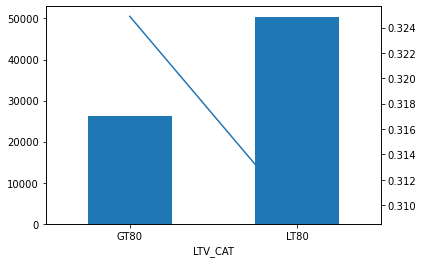

In [123]:
## LTV
ax = Cust_Final_df.groupby(['LTV_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['LTV_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [124]:
# ## ROF
# ax = Cust_Final_df.groupby(['ROF_SEGMENT']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['ROF_SEGMENT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

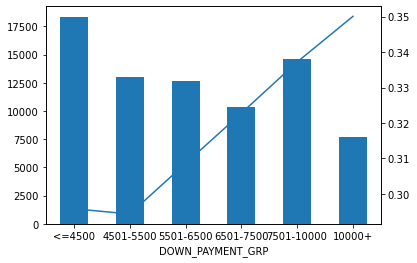

In [125]:
## DOWN_PAYMENT_GRP
ax = Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

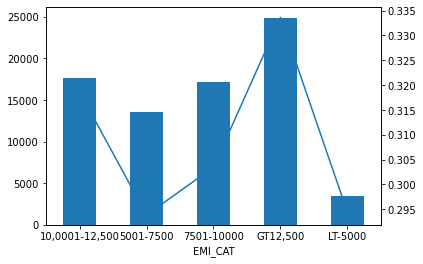

In [126]:
## EMI_CAT

ax = Cust_Final_df.groupby(['EMI_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['EMI_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

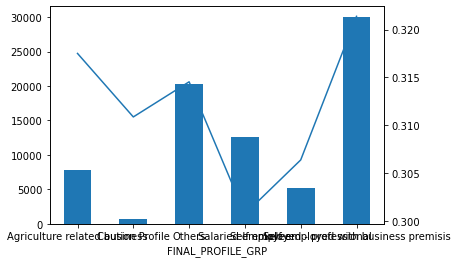

In [127]:
ax = Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


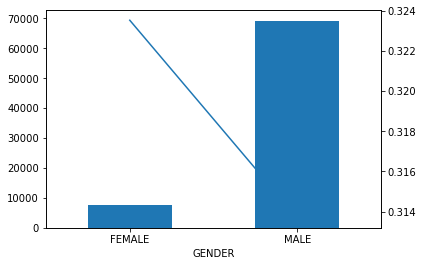

In [128]:
### GENDER
ax = Cust_Final_df.groupby(['GENDER']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['GENDER']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [129]:
# ### DIGITAL_SAVVY
# ax = Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


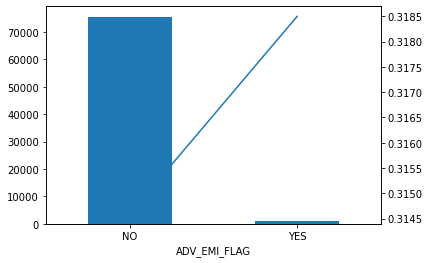

In [130]:
### ADV_EMI_FLAG

ax = Cust_Final_df.groupby(['ADV_EMI_FLAG']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['ADV_EMI_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


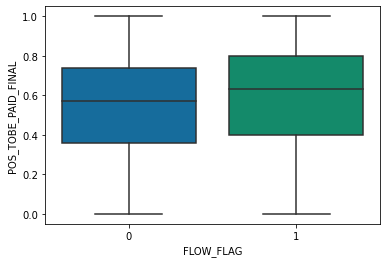

In [131]:
## POS_TOBE_PAID
sns.boxplot(x='FLOW_FLAG',y='POS_TOBE_PAID_FINAL', 
                 data=Cust_Final_df,
                 palette="colorblind"
                 )

## FINAL DATA PREPARATION

In [132]:
complete_df_AUG=Customer_details_df[final_vars].copy()
complete_df_AUG.shape

#bounce_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv')
#bounce_features['YEAR_MONTH'] = pd.to_datetime(bounce_features.YEAR_MONTH,format='%d/%m/%Y')
complete_df_AUG = complete_df_AUG.merge(bounce_engineered_features_df, on = ['AGMTNO'], how = "left")
del bounce_features
print(complete_df_AUG.shape)

# flow_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/flow_engineered_features.csv')
# flow_features['YEAR_MONTH'] = pd.to_datetime(flow_features.YEAR_MONTH)
complete_df_AUG = complete_df_AUG.merge(flow_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
del flow_features
print(complete_df_AUG.shape)


#OD_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/OD_engineered_features.csv')
#OD_features['YEAR_MONTH'] = pd.to_datetime(OD_features.YEAR_MONTH)
complete_df_AUG = complete_df_AUG.merge(OD_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_AUG.shape)

#movement_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv')
#movement_features['YEAR_MONTH'] = pd.to_datetime(movement_features.YEAR_MONTH)
complete_df_AUG = complete_df_AUG.merge(movement_rolling, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
#del movement_features
complete_df_AUG = complete_df_AUG.merge(Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','FLOW_FLAG']], on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_AUG.shape)


(4485, 13)

(76717, 17)
(76717, 20)
(76717, 23)
(76717, 27)


In [133]:
## ADDING MORATORIUM FLAG
complete_df_AUG=complete_df_AUG.merge(MORAT_df,on='AGMTNO',how='left')
complete_df_AUG.MORAT_FLAG.fillna('NO_MORAT',inplace=True)
complete_df_AUG.loc[complete_df_AUG.MORAT_FLAG=='SuoMoto ,Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_AUG.loc[complete_df_AUG.MORAT_FLAG=='SuoMoto ','MORAT_FLAG']='SuoMoto'
complete_df_AUG.loc[complete_df_AUG.MORAT_FLAG=='Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_AUG.MORAT_FLAG.value_counts(dropna=False)
complete_df_AUG.drop(columns={'MORAT_MONTH'},inplace=True)
complete_df_AUG.shape

NO_MORAT    54592
SuoMoto     22125
Name: MORAT_FLAG, dtype: int64

(76717, 28)

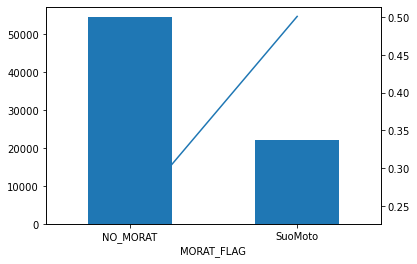

In [134]:
ax = complete_df_AUG.groupby(['MORAT_FLAG']).AGMTNO.count().plot(kind='bar')
complete_df_AUG.groupby(['MORAT_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [135]:
## MISISNG VALUE TREATMENT

complete_df_AUG.isna().sum()
complete_df_AUG.HB_BIN.fillna(complete_df_AUG.HB_BIN.value_counts().index[0],inplace=True)

complete_df_AUG.isna().values.sum()

AGMTNO                      0
ADV_EMI_FLAG                0
GENDER                      0
POS_TOBE_PAID_FINAL         0
FEB_COLLECTIONS_SEGMENTS    0
NEW_COLLECTIONS_SEGMENTS    0
CIBIL_CAT                   0
PROFILE_CODE                0
PROFILE_GROUP               0
LTV_CAT                     0
EMI_CAT                     0
DOWN_PAYMENT_GRP            0
FINAL_PROFILE_GRP           0
YEAR_MONTH                  0
LAST_3MONTH_BOUNCE_COUNT    0
LONGEST_BOUNCE_STREAK       0
LAST_MONTH_BOUNCE           0
LAST_MONTH_FLOW             0
LAST_3MONTH_FLOW_COUNT      0
LFS_BIN                     0
HB_BIN                      1
OD_BIN                      0
ODS_BIN                     0
STAB_BIN                    0
NORM_BIN                    0
RLBK_BIN                    0
FLOW_FLAG                   0
MORAT_FLAG                  0
dtype: int64

0

## DATA PREP FOR SEP-20

In [137]:
## History of CA Agreements of SEP-20
Customer_Hist_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL\CA_HISTORY_SEP_DATA.csv')
Customer_Hist_df.shape
Customer_Hist_df=Customer_Hist_df[Customer_Hist_df.TENOR_COMPLETED=='N']
Customer_Hist_df.shape

(162117, 62)

(102687, 62)

In [138]:
Customer_Hist_df.drop(columns='R',inplace=True)
Customer_Hist_df['YEAR_MONTH'] = [str(i)[3:10] for i in Customer_Hist_df['CUTDATE']]
Customer_Hist_df['YEAR_MONTH'] = pd.to_datetime(Customer_Hist_df.YEAR_MONTH)
Customer_Hist_df = Customer_Hist_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
Customer_Hist_df['PRE_POST_MAR']='BEFORE_MARCH'
Customer_Hist_df.loc[(pd.to_datetime(Customer_Hist_df.AGMT_DATE, format="%d/%m/%Y")> datetime.strptime('01/03/2020',"%d/%m/%Y") ),'PRE_POST_MAR'] ='AFTER_MAR'
Customer_Hist_df['FLOW_FLAG']=np.where(Customer_Hist_df.PAID_COUNT==0,1,0)

In [139]:
Feb_prof=Customer_Hist_df[(Customer_Hist_df.CUTDATE=='29/02/2020')][['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
Feb_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'FEB_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(Feb_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

(102687, 65)

In [140]:
Customer_Hist_df.drop(index=Customer_Hist_df.index[(Customer_Hist_df.AGMTNO=='AGMTNO')],inplace=True)
Customer_Hist_df_SEP=Customer_Hist_df[Customer_Hist_df.CUTDATE=='30/09/2020']
Customer_Hist_df_SEP.shape
# Customer_Hist_df=Customer_Hist_df[Customer_Hist_df.CUTDATE!='31/10/2020']
# Customer_Hist_df.shape

(5694, 65)

In [141]:
New_prof=Customer_Hist_df_SEP[['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
New_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'NEW_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

Customer_Hist_df_SEP=Customer_Hist_df_SEP.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df_SEP.shape

(102687, 66)

(5694, 66)

## BOUNCE VARIABLES

In [143]:
Customer_Hist_df.BOUNCE_FLAG.value_counts(dropna=False)
#Customer_Hist_df['FLOW_FLAG']=np.where(Customer_Hist_df.PAID_COUNT==0,1,0)

1    62942
0    39745
Name: BOUNCE_FLAG, dtype: int64

In [144]:
frame_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'BOUNCE_FLAG','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df = frame_comb_df[['AGMTNO', 'YEAR_MONTH', 'CURRENT_DEMAND_STATUS','FLOW_FLAG','OPENING_BUCKET']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df.loc[frame_df.FLOW_FLAG == 1,'DEMAND_BOUNCE_STATUS'] = 'BOU'
lmb_df = frame_df
lmb_df = lmb_df.groupby('AGMTNO').apply(lambda x: x.BOUNCE_FLAG.shift()).to_frame().reset_index().drop(['level_1'], axis = 1)

lmb_df['YEAR_MONTH'] = frame_df['YEAR_MONTH'].tolist()
lmb_df.columns = ['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']
lmb_df['FLOW_FLAG'] = frame_df['FLOW_FLAG'].tolist()
lmb_df[['LAST_MONTH_BOUNCE']]=lmb_df[['LAST_MONTH_BOUNCE']].fillna(0)

In [145]:
l3mb_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mb_df_1 = l3mb_df.copy()
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
#l3mb_df.LAST_MONTH_BOUNCE.astype(int)
l3mb_df = l3mb_df.groupby('AGMTNO')['LAST_MONTH_BOUNCE'].rolling(3, min_periods = 1).sum().to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
l3mb_df['YEAR_MONTH'] = l3mb_df_1['YEAR_MONTH'].tolist()
l3mb_df.columns = ['AGMTNO', 'LAST_3MONTH_BOUNCE_COUNT', 'YEAR_MONTH']

l3mb_df['FLOW_FLAG'] = l3mb_df_1['FLOW_FLAG'].tolist()


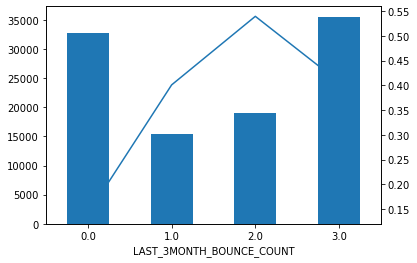

In [146]:
ax = l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).AGMTNO.count().plot(kind='bar')
l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [147]:
##### LONGEST_BOUNCE_STREAK

lbs_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lbs_df_1 = lbs_df.copy()
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
lbs_df = lbs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_BOUNCE * (y.LAST_MONTH_BOUNCE.groupby((y.LAST_MONTH_BOUNCE != y.LAST_MONTH_BOUNCE.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lbs_df.columns = ['AGMTNO', 'LONGEST_BOUNCE_STREAK', 'YEAR_MONTH']

lbs_df['FLOW_FLAG'] = lbs_df_1['FLOW_FLAG'].tolist()
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
#lbs_df = pd.merge(lbs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

In [148]:
# lbs_df.groupby(['LONGEST_BOUNCE_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())
# lbs_df

cut_labels_4 = ['0', '1', '2', '3','4+']
cut_bins = [-1, 0, 1, 2,3,100]
lbs_df['LBS_BIN']=pd.cut(lbs_df.LONGEST_BOUNCE_STREAK, bins=cut_bins, labels=cut_labels_4)

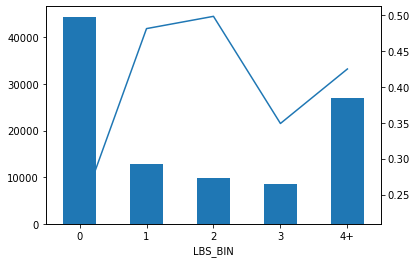

In [149]:
ax = lbs_df.groupby(['LBS_BIN']).AGMTNO.count().plot(kind='bar')
lbs_df.groupby(['LBS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)
# plt.xticks(rotation=90)
# #plt.Figure(10,10)
# # plt.figure(figsize=(10,10)) 

In [150]:
## MERGING BOUNCE FEATURES

bounce_engineered_features_df = l3mb_df

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lbs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_BOUNCE_STREAK']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lmb_df[['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = bounce_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE']]
bounce_engineered_features_df.columns = ['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK','LAST_MONTH_BOUNCE']

bounce_engineered_features_df[['LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK']].fillna(0, inplace = True)
bounce_engineered_features_df[['LAST_MONTH_BOUNCE']].fillna(0, inplace = True)
bounce_engineered_features_df.columns,bounce_engineered_features_df.shape
bounce_engineered_features_df.shape
#bounce_engineered_features_df.to_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv',index=False)

(Index(['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT',
        'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE'],
       dtype='object'), (102687, 5))

(102687, 5)

## OD Related Varaibales

In [151]:
##### HIGHEST_BUCKET

hb_df = Customer_Hist_df[['AGMTNO','YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']]
hb_df = hb_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
hb_df['HIGHEST_BUCKET'] = hb_df.groupby('AGMTNO').OPEN_DPD_BKT_GRP.cummax().shift()

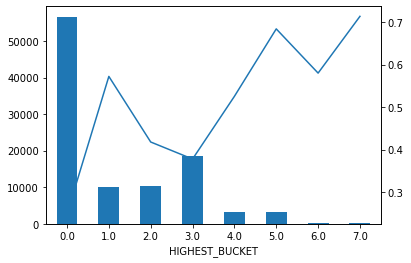

In [152]:
ax = hb_df.groupby(['HIGHEST_BUCKET']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HIGHEST_BUCKET']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [153]:
cut_labels_5 = ['0', '1', '2', '3','4','5+']
cut_bins = [-1, 0, 1, 2,3,4,100]
hb_df['HB_BIN']=pd.cut(hb_df.HIGHEST_BUCKET, bins=cut_bins, labels=cut_labels_5)

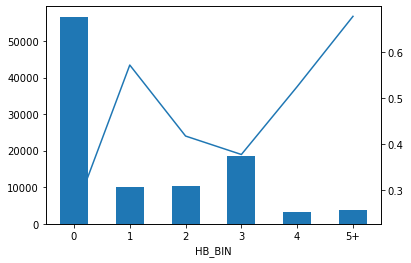

In [154]:
ax = hb_df.groupby(['HB_BIN']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [155]:
## How many times in OD

##### LONGEST_OD_STREAK

los_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
los_df_1 = los_df.copy()
los_df.loc[los_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
los_df.loc[los_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
#los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG * (y.OD_CATG.groupby((y.OD_CATG != y.OD_CATG.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.cumsum().shift()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)

los_df['YEAR_MONTH'] = los_df_1['YEAR_MONTH'].tolist()
#los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
los_df.columns = ['AGMTNO', 'TIMES_IN_OD', 'YEAR_MONTH']
los_df['OPEN_DPD_BKT_GRP'] = los_df_1['OPEN_DPD_BKT_GRP'].tolist()
los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
#los_df=los_df.merge(frame_comb_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
los_df.shape
#los_df['CURRENT_DEMAND_STATUS'] = los_df_1 ['CURRENT_DEMAND_STATUS'].tolist()

(102687, 5)

In [156]:
los_df['OD_BIN']=np.where(los_df.TIMES_IN_OD>0, 'NO', 'YES')

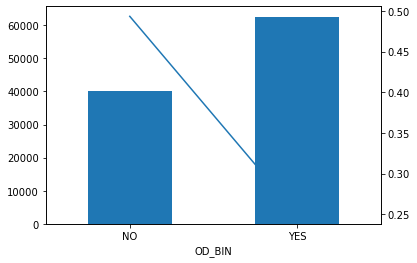

In [157]:
ax = los_df.groupby(['OD_BIN']).AGMTNO.count().plot(kind='bar')
los_df.groupby(['OD_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [158]:
lods_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
                                                                                                                                                                           
lods_df_1 = lods_df.copy()
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
lods_df= lods_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.groupby((y['OD_CATG'] == 0).cumsum().shift()).cumcount()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lods_df['YEAR_MONTH'] = lods_df_1['YEAR_MONTH'].tolist()
#lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
lods_df.columns = ['AGMTNO', 'OD_STREAK', 'YEAR_MONTH']
lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
#lods_df['OPENING_BUCKET'] = lods_df_1 ['OPENING_BUCKET'].tolist()
#lods_df=lods_df.merge(OD_frame_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
lods_df.shape

(102687, 4)

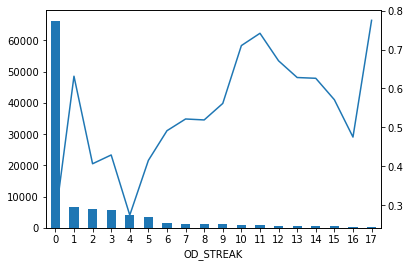

In [159]:
ax = lods_df.groupby(['OD_STREAK']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['OD_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [160]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lods_df['ODS_BIN']=pd.cut(lods_df.OD_STREAK, bins=cut_bins, labels=cut_labels_4)

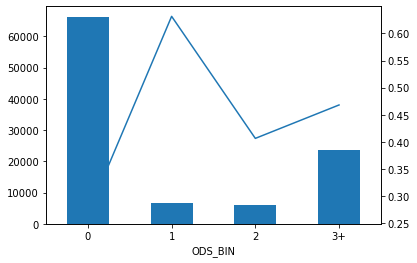

In [161]:
ax = lods_df.groupby(['ODS_BIN']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['ODS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [162]:
OD_engineered_features_df = los_df.copy()

OD_engineered_features_df = pd.merge(OD_engineered_features_df, hb_df[['AGMTNO', 'HB_BIN', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

OD_engineered_features_df = pd.merge(OD_engineered_features_df, lods_df[['AGMTNO', 'YEAR_MONTH', 'ODS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#OD_engineered_features_df.fillna(0, inplace = True)


OD_engineered_features_df = OD_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'HB_BIN','OD_BIN','ODS_BIN']]

OD_engineered_features_df.shape


(102687, 5)

## MOVEMENT VARIBALES

In [163]:
frame_df=Customer_Hist_df.copy()
frame_df['movement'] = None
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == 0)), 'movement'] = 'normalize'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET < frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'rollback'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'stabilize'

movement = frame_df.groupby(['AGMTNO', 'YEAR_MONTH']).movement.value_counts().unstack().reset_index()
movement.sort_values(by = "YEAR_MONTH", ascending = True, inplace = True)
movement.fillna(0, inplace = True)

#### check for movement columns and add manually if missing 
if('rollback' not in movement.columns):
   movement['rollback'] = 0
   
if('normalize' not in movement.columns):
   movement['normalize'] = 0

if('stabilize' not in movement.columns):
   movement['stabilize']= 0
####

movement_merge = frame_df.merge(movement, how = "left", on = ['AGMTNO', 'YEAR_MONTH'])
movement_merge.sort_values(by = "YEAR_MONTH", inplace = True)

movement_rolling = movement_merge.groupby("AGMTNO")[['normalize', 'rollback', 'stabilize']].transform(lambda x : x.expanding().sum().shift(1))
movement_rolling = movement_rolling.rename(columns = {"normalize": "normalize_total", "rollback": "rollback_total", "stabilize": "stabilize_total"})
movement_rolling = pd.concat([movement_merge, movement_rolling], axis = 1)
movement_rolling = movement_rolling[['AGMTNO', 'YEAR_MONTH', 'normalize_total', 'rollback_total', 'stabilize_total','FLOW_FLAG']].fillna(0)

#movement_rolling .to_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv',index=False)
# # filtering for focus year month
# movement_rolling = movement_rolling.loc[movement_rolling.YEAR_MONTH == focus_year_month, :]


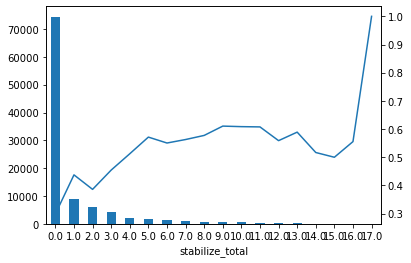

In [164]:
ax = movement_rolling.groupby(['stabilize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['stabilize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [165]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
movement_rolling['STAB_BIN']=pd.cut(movement_rolling.stabilize_total, bins=cut_bins, labels=cut_labels_4)

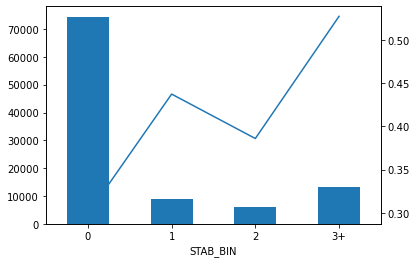

In [166]:
ax = movement_rolling.groupby(['STAB_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['STAB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


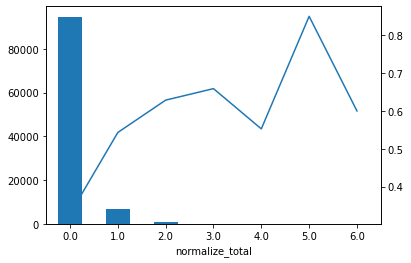

In [167]:
ax = movement_rolling.groupby(['normalize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['normalize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [168]:
cut_labels_4 = ['NOT_NORM', 'NORM']
cut_bins = [-1, 0,100]
movement_rolling['NORM_BIN']=pd.cut(movement_rolling.normalize_total, bins=cut_bins, labels=cut_labels_4)

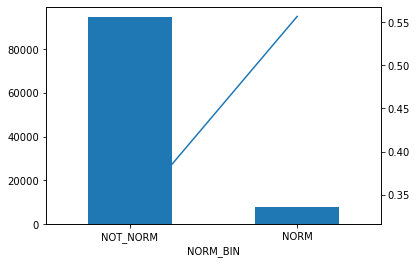

In [169]:
ax = movement_rolling.groupby(['NORM_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['NORM_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [170]:
cut_labels_4 = ['NO', 'YES']
cut_bins = [-1, 0,100]
movement_rolling['RLBK_BIN']=pd.cut(movement_rolling.rollback_total, bins=cut_bins, labels=cut_labels_4)

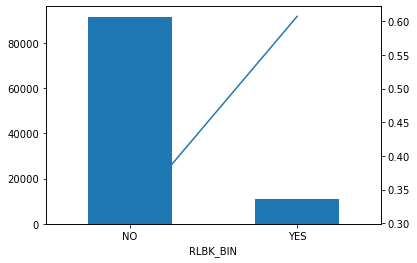

In [171]:
ax = movement_rolling.groupby(['RLBK_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['RLBK_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [172]:
movement_rolling=movement_rolling[['AGMTNO', 'YEAR_MONTH', 'STAB_BIN', 'NORM_BIN','RLBK_BIN']]
movement_rolling.shape

(102687, 5)

## FLOW VARIABLES

In [173]:
##### LAST MONTH FLOW
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
lmf_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lmf_df_1 = lmf_df.copy()
lmf_df = lmf_df.groupby('AGMTNO').apply(lambda x: x.FLOW_FLAG.shift()).to_frame().reset_index().drop(columns=['level_1'])
lmf_df.columns = ['AGMTNO', 'LAST_MONTH_FLOW']
lmf_df.LAST_MONTH_FLOW.fillna(False, inplace = True)
lmf_df.LAST_MONTH_FLOW = lmf_df.LAST_MONTH_FLOW.fillna(0).astype(int)
lmf_df['YEAR_MONTH'] = lmf_df_1['YEAR_MONTH'].tolist()
lmf_df['FLOW_FLAG'] = lmf_df_1['FLOW_FLAG'].fillna(0).astype(int).tolist()

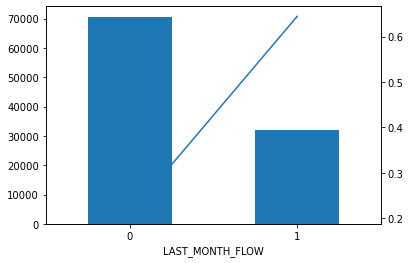

In [174]:
ax = lmf_df.groupby(['LAST_MONTH_FLOW']).AGMTNO.count().plot(kind='bar')
lmf_df.groupby(['LAST_MONTH_FLOW']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [175]:

##### LAST 3 MONTH FLOW COUNT

l3mf_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
l3mf_df_1 = l3mf_df.copy()
l3mf_df = l3mf_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mf_df = l3mf_df.groupby('AGMTNO')['LAST_MONTH_FLOW'].rolling(3, min_periods=1).sum().to_frame().reset_index().drop(['level_1'], axis=1)
l3mf_df.columns = ['AGMTNO', 'LAST_3MONTH_FLOW_COUNT']
l3mf_df['YEAR_MONTH'] = l3mf_df_1['YEAR_MONTH']
l3mf_df['FLOW_FLAG'] = l3mf_df_1['FLOW_FLAG'].tolist()


In [176]:
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())

LAST_3MONTH_FLOW_COUNT
0.00   0.16
1.00   0.44
2.00   0.56
3.00   0.72
dtype: float64

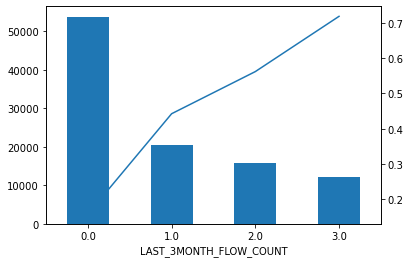

In [177]:
ax = l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).AGMTNO.count().plot(kind='bar')
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [178]:
#### LONGEST FLOW STREAK

lfs_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
lfs_df_1 = lfs_df.copy()
lfs_df = lfs_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
lfs_df = lfs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_FLOW * (y.LAST_MONTH_FLOW.groupby((y.LAST_MONTH_FLOW != y.LAST_MONTH_FLOW.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis=1)
lfs_df.columns = ['AGMTNO', 'LFS']
lfs_df['YEAR_MONTH'] = lfs_df_1['YEAR_MONTH']
lfs_df['LONGEST_FLOW_STREAK'] = lfs_df.groupby('AGMTNO')['LFS'].apply(lambda x : x.expanding().max()).reset_index(drop=True)
lfs_df = lfs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_FLOW_STREAK']]
lfs_df['FLOW_FLAG'] = lfs_df_1['FLOW_FLAG']
# frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
# lfs_df = pd.merge(lfs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')


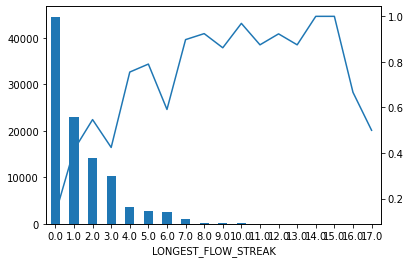

In [179]:
ax = lfs_df.groupby(['LONGEST_FLOW_STREAK']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LONGEST_FLOW_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [180]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lfs_df['LFS_BIN']=pd.cut(lfs_df.LONGEST_FLOW_STREAK, bins=cut_bins, labels=cut_labels_4)

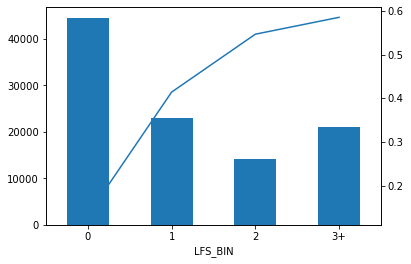

In [181]:
ax = lfs_df.groupby(['LFS_BIN']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LFS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [182]:
## MERGING FLOW FEATURES

flow_engineered_features_df = l3mf_df

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lfs_df[['AGMTNO', 'YEAR_MONTH', 'LFS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lmf_df, on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#flow_engineered_features_df.fillna(0, inplace = True)

flow_engineered_features_df = flow_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW', 'LAST_3MONTH_FLOW_COUNT', 'LFS_BIN']]

flow_engineered_features_df.shape


(102687, 5)

## DEMOGRAPHIC VARIABLES

In [183]:
#Customer_details_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL_CUST_PROFILE_DATA.csv')
Customer_details_df=Customer_Hist_df_SEP[Static_cols]
Customer_details_df.shape


(5694, 37)

In [184]:

Customer_details_df.loc[Customer_details_df.GENDER=='M','GENDER']='MALE'
Customer_details_df.loc[Customer_details_df.GENDER=='F','GENDER']='FEMALE'
Customer_details_df.GENDER.fillna(Customer_details_df.GENDER.value_counts().index[0],inplace=True)
#Customer_details_df.GENDER.value_counts()

Customer_details_df.CIBIL_SCORE.fillna(-1.000, inplace = True)
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE=='LOW_RISK'),'CIBIL_SCORE'] = 750

Customer_details_df['CIBIL_CAT']=None
Customer_details_df['CIBIL_CAT']= np.where((Customer_details_df.CIBIL_SCORE<5),'NEW',np.where(((Customer_details_df.CIBIL_SCORE >=700)& (Customer_details_df.CIBIL_SCORE<=900)),'CREAMY',0))
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=5)& (Customer_details_df.CIBIL_SCORE<=400)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=401)& (Customer_details_df.CIBIL_SCORE<700)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE==-1),'CIBIL_CAT'] = 'NEW'
Customer_details_df.loc[(Customer_details_df.CIBIL_CAT=="0"),'CIBIL_CAT'] = 'NEW'



Master_Cust_Profile = pd.read_csv('D:/Collections/RoF-UC/Master_Profile_Code.csv',encoding='cp1252')
# Master_Model_Code = pd.read_csv('D:/Collections/RoF-UC/Master_Model_Code.csv',encoding='cp1252')

Customer_details_df.CUSTOMER_PROFILE_CODE.fillna(Customer_details_df.CUSTOMER_PROFILE_CODE.value_counts().index[0],inplace=True)
Customer_details_df=Customer_details_df.merge(Master_Cust_Profile[['PROFILE_CODE','PROFILE_GROUP']],left_on='CUSTOMER_PROFILE_CODE'\
                                 ,right_on='PROFILE_CODE',how='left')
Customer_details_df.PROFILE_GROUP.fillna('Others',inplace=True)

# Customer_details_df=Customer_details_df.merge(Master_Model_Code[['MODEL_CODE','MODEL_YEAR','MODEL_SEGMENT']],on='MODEL_CODE',how='left')
# Customer_details_df.MODEL_SEGMENT.fillna(Customer_details_df.MODEL_SEGMENT.value_counts().index[0],inplace=True)


Customer_details_df['LTV_CAT']= np.where((Customer_details_df.LTV>80),'GT80','LT80')

### FOR CA ########################
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10,000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

Customer_details_df.DOWN_PAYMENT.fillna(Customer_details_df.DOWN_PAYMENT.mean(),inplace=True)
cut_labels_5 = ['<=4500', '4501-5500', '5501-6500','6501-7500','7501-10000','10000+']
cut_bins = [-1, 4500, 5500, 6500,7500,10000,1000000]
Customer_details_df['DOWN_PAYMENT_GRP']=pd.cut(Customer_details_df.DOWN_PAYMENT, bins=cut_bins, labels=cut_labels_5)

Customer_details_df.rename(columns={'AREA_DISPALY_NAME':'AREA_NAME','REGIONAL_GROUPING':'REGION'},inplace=True)
Customer_details_df.AREA_NAME.fillna(Customer_details_df.AREA_NAME.value_counts().index[0],inplace=True)

## EMI_CAT
# Customer_details_df['EMI_CAT']=None
# Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-2500'
# #Customer_details_df.loc[Customer_details_df.EMI>=1000,'EMI_CAT']= '1000-2500'
# Customer_details_df.loc[Customer_details_df.EMI>2500,'EMI_CAT']= '2500-5000'
# Customer_details_df.loc[Customer_details_df.EMI> 5000,'EMI_CAT']= 'GT5000'

############ FOR CA #######################

Customer_details_df['EMI_CAT']=None
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

## Customer Profile 
a_p=['Finance related business','Hotel business related','Real estate / Construction related business','Rental Income earner'
    ,'Transport realted business','Pension / Husband income / parental income']
Customer_details_df['FINAL_PROFILE_GRP']=Customer_details_df.PROFILE_GROUP.tolist()
Customer_details_df.loc[Customer_details_df.PROFILE_GROUP.isin(a_p),'FINAL_PROFILE_GRP']='Others'
Customer_details_df.FINAL_PROFILE_GRP.value_counts(dropna=False)

### DIGITAL_SAVVY
#Customer_details_df.DIGITAL_SAVVY_FLAG.fillna(Customer_details_df.DIGITAL_SAVVY_FLAG.value_counts().index[0],inplace=True)

### ADV_EMI_FLAG
Customer_details_df.ADVANCE_EMI_COUNT.fillna(Customer_details_df.ADVANCE_EMI_COUNT.mean(),inplace=True)
Customer_details_df['ADV_EMI_FLAG']=np.where(Customer_details_df.ADVANCE_EMI_COUNT>0,'YES', 'NO')

## POS_TOBE_PAID
Customer_details_df['POS_TOBE_PAID_FINAL']=round((Customer_details_df.POS/Customer_details_df.LOAN_AMOUNT),2)

Customer_details_df.POS_TOBE_PAID_FINAL.fillna(Customer_details_df.POS_TOBE_PAID_FINAL.mean(),inplace=True)
Customer_details_df.loc[Customer_details_df.POS_TOBE_PAID_FINAL >1, 'POS_TOBE_PAID_FINAL']=1


# final_vars=[ 'AGMTNO','DIGITAL_SAVVY_FLAG', 'ROF_SEGMENT','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL'
#             ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df.FEB_COLLECTIONS_SEGMENTS.fillna(Customer_details_df.FEB_COLLECTIONS_SEGMENTS.value_counts().index[0],inplace=True)
final_vars=[ 'AGMTNO','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL','FEB_COLLECTIONS_SEGMENTS','NEW_COLLECTIONS_SEGMENTS'
            ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df[final_vars].isnull().sum()


Self employed with business premisis    2197
Others                                  1527
Salaried employee                        945
Agriculture related business             580
Self employed - professional             380
Caution Profile                           65
Name: FINAL_PROFILE_GRP, dtype: int64

AGMTNO                      0
ADV_EMI_FLAG                0
GENDER                      0
POS_TOBE_PAID_FINAL         0
FEB_COLLECTIONS_SEGMENTS    0
NEW_COLLECTIONS_SEGMENTS    0
CIBIL_CAT                   0
PROFILE_CODE                0
PROFILE_GROUP               0
LTV_CAT                     0
EMI_CAT                     0
DOWN_PAYMENT_GRP            0
FINAL_PROFILE_GRP           0
dtype: int64

## EDA on DEMO Variables

In [185]:
Rest_cols=set(Customer_Hist_df.columns.to_list()) - set(Static_cols)
Rest_cols.add('AGMTNO')
Rest_cols= list(Rest_cols)
#Rest_cols

In [186]:
Cust_Final_df=pd.DataFrame()
Cust_Final_df=pd.merge(Customer_Hist_df[Rest_cols],Customer_details_df,on='AGMTNO',how='inner')
Cust_Final_df.shape


(99341, 75)

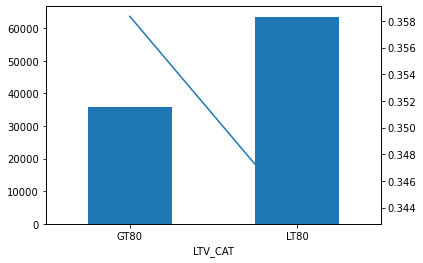

In [187]:
## LTV
ax = Cust_Final_df.groupby(['LTV_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['LTV_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [188]:
# ## ROF
# ax = Cust_Final_df.groupby(['ROF_SEGMENT']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['ROF_SEGMENT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

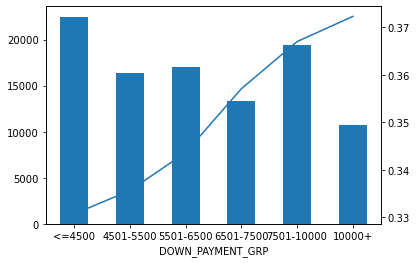

In [189]:
## DOWN_PAYMENT_GRP
ax = Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

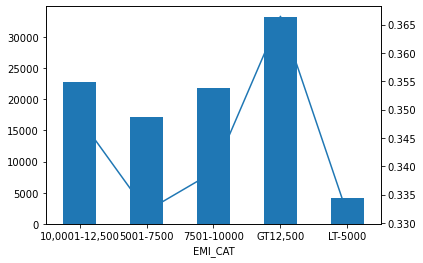

In [190]:
## EMI_CAT

ax = Cust_Final_df.groupby(['EMI_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['EMI_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

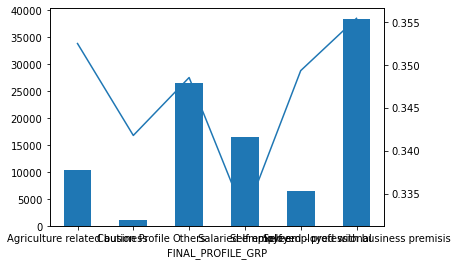

In [191]:
ax = Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


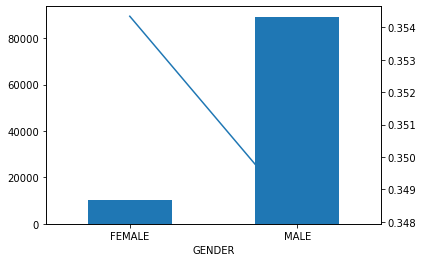

In [192]:
### GENDER
ax = Cust_Final_df.groupby(['GENDER']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['GENDER']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [193]:
# ### DIGITAL_SAVVY
# ax = Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


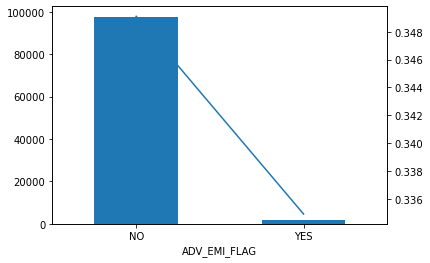

In [194]:
### ADV_EMI_FLAG

ax = Cust_Final_df.groupby(['ADV_EMI_FLAG']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['ADV_EMI_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


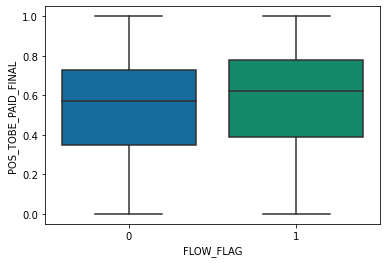

In [195]:
## POS_TOBE_PAID
sns.boxplot(x='FLOW_FLAG',y='POS_TOBE_PAID_FINAL', 
                 data=Cust_Final_df,
                 palette="colorblind"
                 )

## FINAL DATA PREPARATION

In [196]:
complete_df_SEP=Customer_details_df[final_vars].copy()
complete_df_SEP.shape

#bounce_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv')
#bounce_features['YEAR_MONTH'] = pd.to_datetime(bounce_features.YEAR_MONTH,format='%d/%m/%Y')
complete_df_SEP = complete_df_SEP.merge(bounce_engineered_features_df, on = ['AGMTNO'], how = "left")
#del bounce_features
print(complete_df_SEP.shape)

# flow_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/flow_engineered_features.csv')
# flow_features['YEAR_MONTH'] = pd.to_datetime(flow_features.YEAR_MONTH)
complete_df_SEP = complete_df_SEP.merge(flow_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
#del flow_features
print(complete_df_SEP.shape)


#OD_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/OD_engineered_features.csv')
#OD_features['YEAR_MONTH'] = pd.to_datetime(OD_features.YEAR_MONTH)
complete_df_SEP = complete_df_SEP.merge(OD_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_SEP.shape)

#movement_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv')
#movement_features['YEAR_MONTH'] = pd.to_datetime(movement_features.YEAR_MONTH)
complete_df_SEP = complete_df_SEP.merge(movement_rolling, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
#del movement_features
complete_df_SEP = complete_df_SEP.merge(Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','FLOW_FLAG']], on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_SEP.shape)


(5694, 13)

(99341, 17)
(99341, 20)
(99341, 23)
(99341, 27)


In [197]:
## AADING MORATORIUM FLAG
complete_df_SEP=complete_df_SEP.merge(MORAT_df,on='AGMTNO',how='left')
complete_df_SEP.MORAT_FLAG.fillna('NO_MORAT',inplace=True)
complete_df_SEP.loc[complete_df_SEP.MORAT_FLAG=='SuoMoto ,Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_SEP.loc[complete_df_SEP.MORAT_FLAG=='SuoMoto ','MORAT_FLAG']='SuoMoto'
complete_df_SEP.loc[complete_df_SEP.MORAT_FLAG=='Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_SEP.MORAT_FLAG.value_counts(dropna=False)
complete_df_SEP.drop(columns={'MORAT_MONTH'},inplace=True)
complete_df_SEP.shape

NO_MORAT    49976
SuoMoto     49365
Name: MORAT_FLAG, dtype: int64

(99341, 28)

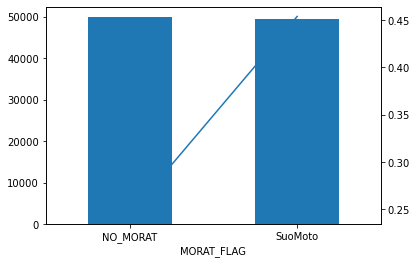

In [198]:
ax = complete_df_SEP.groupby(['MORAT_FLAG']).AGMTNO.count().plot(kind='bar')
complete_df_SEP.groupby(['MORAT_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [199]:
## MISISNG VALUE TREATMENT

complete_df_SEP.isna().sum()
complete_df_SEP.HB_BIN.fillna(complete_df_SEP.HB_BIN.value_counts().index[0],inplace=True)

complete_df_SEP.isna().values.sum()

AGMTNO                      0
ADV_EMI_FLAG                0
GENDER                      0
POS_TOBE_PAID_FINAL         0
FEB_COLLECTIONS_SEGMENTS    0
NEW_COLLECTIONS_SEGMENTS    0
CIBIL_CAT                   0
PROFILE_CODE                0
PROFILE_GROUP               0
LTV_CAT                     0
EMI_CAT                     0
DOWN_PAYMENT_GRP            0
FINAL_PROFILE_GRP           0
YEAR_MONTH                  0
LAST_3MONTH_BOUNCE_COUNT    0
LONGEST_BOUNCE_STREAK       0
LAST_MONTH_BOUNCE           0
LAST_MONTH_FLOW             0
LAST_3MONTH_FLOW_COUNT      0
LFS_BIN                     0
HB_BIN                      1
OD_BIN                      0
ODS_BIN                     0
STAB_BIN                    0
NORM_BIN                    0
RLBK_BIN                    0
FLOW_FLAG                   0
MORAT_FLAG                  0
dtype: int64

0

## DATA PREP FOR OCT-20

In [1657]:
## History of CA Agreements of OCT-20
Customer_Hist_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL\CA_HISTORY_OCT_DATA_2.csv')
Customer_Hist_df.shape
# Customer_Hist_df=Customer_Hist_df[Customer_Hist_df.TENOR_COMPLETED=='N']
# Customer_Hist_df.shape

(71997, 61)

In [1658]:
Customer_Hist_df.drop(columns='R',inplace=True)
Customer_Hist_df['YEAR_MONTH'] = [str(i)[3:10] for i in Customer_Hist_df['CUTDATE']]
Customer_Hist_df['YEAR_MONTH'] = pd.to_datetime(Customer_Hist_df.YEAR_MONTH)
Customer_Hist_df = Customer_Hist_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
Customer_Hist_df['PRE_POST_MAR']='BEFORE_MARCH'
Customer_Hist_df.loc[(pd.to_datetime(Customer_Hist_df.AGMT_DATE, format="%d/%m/%Y")> datetime.strptime('01/03/2020',"%d/%m/%Y") ),'PRE_POST_MAR'] ='AFTER_MAR'
Customer_Hist_df['FLOW_FLAG']=np.where(Customer_Hist_df.PAID_COUNT==0,1,0)

In [1659]:
Feb_prof=Customer_Hist_df[(Customer_Hist_df.CUTDATE=='29/02/2020')][['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
Feb_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'FEB_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(Feb_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

(71997, 64)

In [1660]:
Customer_Hist_df.drop(index=Customer_Hist_df.index[(Customer_Hist_df.AGMTNO=='AGMTNO')],inplace=True)
Customer_Hist_df_OCT=Customer_Hist_df[Customer_Hist_df.CUTDATE=='31/10/2020']
Customer_Hist_df_OCT.shape
# Customer_Hist_df=Customer_Hist_df[Customer_Hist_df.CUTDATE!='31/10/2020']
# Customer_Hist_df.shape

(2451, 64)

In [1661]:
New_prof=Customer_Hist_df_OCT[['AGMTNO','CL_COLLECTIONS_SEGMENTS']]
New_prof.rename(columns={'CL_COLLECTIONS_SEGMENTS':'NEW_COLLECTIONS_SEGMENTS'},inplace=True)

Customer_Hist_df=Customer_Hist_df.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df.shape

Customer_Hist_df_OCT=Customer_Hist_df_OCT.merge(New_prof,on='AGMTNO',how='left')
Customer_Hist_df_OCT.shape

(71997, 65)

(2451, 65)

## BOUNCE VARIABLES

In [1663]:
Customer_Hist_df.BOUNCE_FLAG.value_counts(dropna=False)
#Customer_Hist_df['FLOW_FLAG']=np.where(Customer_Hist_df.PAID_COUNT==0,1,0)

1    41565
0    30432
Name: BOUNCE_FLAG, dtype: int64

In [1664]:
frame_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'BOUNCE_FLAG','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df = frame_comb_df[['AGMTNO', 'YEAR_MONTH', 'CURRENT_DEMAND_STATUS','FLOW_FLAG','OPENING_BUCKET']].sort_values(['AGMTNO', 'YEAR_MONTH'])
#frame_df.loc[frame_df.FLOW_FLAG == 1,'DEMAND_BOUNCE_STATUS'] = 'BOU'
lmb_df = frame_df
lmb_df = lmb_df.groupby('AGMTNO').apply(lambda x: x.BOUNCE_FLAG.shift()).to_frame().reset_index().drop(['level_1'], axis = 1)

lmb_df['YEAR_MONTH'] = frame_df['YEAR_MONTH'].tolist()
lmb_df.columns = ['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']
lmb_df['FLOW_FLAG'] = frame_df['FLOW_FLAG'].tolist()
lmb_df[['LAST_MONTH_BOUNCE']]=lmb_df[['LAST_MONTH_BOUNCE']].fillna(0)

In [1665]:
l3mb_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mb_df_1 = l3mb_df.copy()
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# l3mb_df.loc[l3mb_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
#l3mb_df.LAST_MONTH_BOUNCE.astype(int)
l3mb_df = l3mb_df.groupby('AGMTNO')['LAST_MONTH_BOUNCE'].rolling(3, min_periods = 1).sum().to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
l3mb_df['YEAR_MONTH'] = l3mb_df_1['YEAR_MONTH'].tolist()
l3mb_df.columns = ['AGMTNO', 'LAST_3MONTH_BOUNCE_COUNT', 'YEAR_MONTH']

l3mb_df['FLOW_FLAG'] = l3mb_df_1['FLOW_FLAG'].tolist()


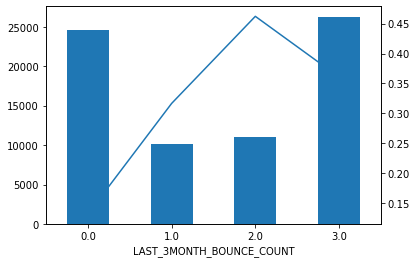

In [1666]:
ax = l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).AGMTNO.count().plot(kind='bar')
l3mb_df.groupby(['LAST_3MONTH_BOUNCE_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [1667]:
##### LONGEST_BOUNCE_STREAK

lbs_df = lmb_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_BOUNCE','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lbs_df_1 = lbs_df.copy()
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'CLR', 'LAST_MONTH_BOUNCE'] = 0
# lbs_df.loc[lbs_df.LAST_MONTH_BOUNCE == 'BOU', 'LAST_MONTH_BOUNCE'] = 1
lbs_df = lbs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_BOUNCE * (y.LAST_MONTH_BOUNCE.groupby((y.LAST_MONTH_BOUNCE != y.LAST_MONTH_BOUNCE.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lbs_df.columns = ['AGMTNO', 'LONGEST_BOUNCE_STREAK', 'YEAR_MONTH']

lbs_df['FLOW_FLAG'] = lbs_df_1['FLOW_FLAG'].tolist()
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
#lbs_df = pd.merge(lbs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

In [1668]:
# lbs_df.groupby(['LONGEST_BOUNCE_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())
# lbs_df

cut_labels_4 = ['0', '1', '2', '3','4+']
cut_bins = [-1, 0, 1, 2,3,100]
lbs_df['LBS_BIN']=pd.cut(lbs_df.LONGEST_BOUNCE_STREAK, bins=cut_bins, labels=cut_labels_4)

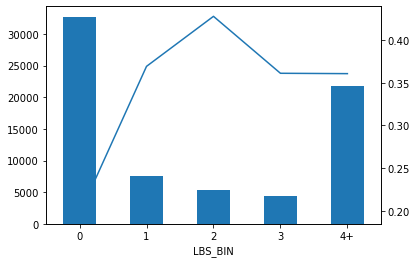

In [1669]:
ax = lbs_df.groupby(['LBS_BIN']).AGMTNO.count().plot(kind='bar')
lbs_df.groupby(['LBS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)
# plt.xticks(rotation=90)
# #plt.Figure(10,10)
# # plt.figure(figsize=(10,10)) 

In [1670]:
## MERGING BOUNCE FEATURES

bounce_engineered_features_df = l3mb_df

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lbs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_BOUNCE_STREAK']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = pd.merge(bounce_engineered_features_df, lmb_df[['AGMTNO', 'LAST_MONTH_BOUNCE', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

bounce_engineered_features_df = bounce_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE']]
bounce_engineered_features_df.columns = ['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK','LAST_MONTH_BOUNCE']

bounce_engineered_features_df[['LAST_3MONTH_BOUNCE_COUNT', 'LONGEST_BOUNCE_STREAK']].fillna(0, inplace = True)
bounce_engineered_features_df[['LAST_MONTH_BOUNCE']].fillna(0, inplace = True)
bounce_engineered_features_df.columns,bounce_engineered_features_df.shape
bounce_engineered_features_df.shape
#bounce_engineered_features_df.to_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv',index=False)

(Index(['AGMTNO', 'YEAR_MONTH', 'LAST_3MONTH_BOUNCE_COUNT',
        'LONGEST_BOUNCE_STREAK', 'LAST_MONTH_BOUNCE'],
       dtype='object'), (71997, 5))

(71997, 5)

## OD Related Varaibales

In [1671]:
##### HIGHEST_BUCKET

hb_df = Customer_Hist_df[['AGMTNO','YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']]
hb_df = hb_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
hb_df['HIGHEST_BUCKET'] = hb_df.groupby('AGMTNO').OPEN_DPD_BKT_GRP.cummax().shift()

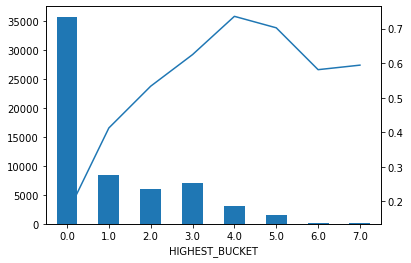

In [1672]:
ax = hb_df.groupby(['HIGHEST_BUCKET']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HIGHEST_BUCKET']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1673]:
cut_labels_5 = ['0', '1', '2', '3','4','5+']
cut_bins = [-1, 0, 1, 2,3,4,100]
hb_df['HB_BIN']=pd.cut(hb_df.HIGHEST_BUCKET, bins=cut_bins, labels=cut_labels_5)

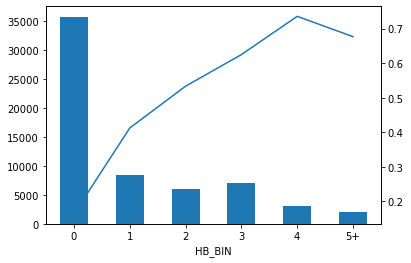

In [1674]:
ax = hb_df.groupby(['HB_BIN']).AGMTNO.count().plot(kind='bar')
hb_df.groupby(['HB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1675]:
## How many times in OD

##### LONGEST_OD_STREAK

los_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
los_df_1 = los_df.copy()
los_df.loc[los_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
los_df.loc[los_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
#los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG * (y.OD_CATG.groupby((y.OD_CATG != y.OD_CATG.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
los_df = los_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.cumsum().shift()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)

los_df['YEAR_MONTH'] = los_df_1['YEAR_MONTH'].tolist()
#los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
los_df.columns = ['AGMTNO', 'TIMES_IN_OD', 'YEAR_MONTH']
los_df['OPEN_DPD_BKT_GRP'] = los_df_1['OPEN_DPD_BKT_GRP'].tolist()
los_df['FLOW_FLAG'] = los_df_1['FLOW_FLAG'].tolist()
#los_df=los_df.merge(frame_comb_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
los_df.shape
#los_df['CURRENT_DEMAND_STATUS'] = los_df_1 ['CURRENT_DEMAND_STATUS'].tolist()

(71997, 5)

In [1676]:
los_df['OD_BIN']=np.where(los_df.TIMES_IN_OD>0, 'NO', 'YES')

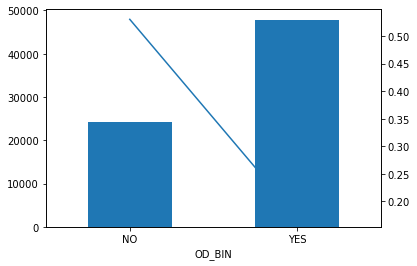

In [1677]:
ax = los_df.groupby(['OD_BIN']).AGMTNO.count().plot(kind='bar')
los_df.groupby(['OD_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1678]:
lods_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','OPEN_DPD_BKT_GRP','FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
                                                                                                                                                                           
lods_df_1 = lods_df.copy()
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP == 0, 'OD_CATG'] = 0
lods_df.loc[lods_df.OPEN_DPD_BKT_GRP > 0, 'OD_CATG'] = 1
lods_df= lods_df.groupby('AGMTNO').apply(lambda y: y.OD_CATG.groupby((y['OD_CATG'] == 0).cumsum().shift()).cumcount()).to_frame().reset_index().drop(['level_1'], axis = 1).fillna(0)
lbs_df['YEAR_MONTH'] = lbs_df_1['YEAR_MONTH'].tolist()
lods_df['YEAR_MONTH'] = lods_df_1['YEAR_MONTH'].tolist()
#lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
lods_df.columns = ['AGMTNO', 'OD_STREAK', 'YEAR_MONTH']
lods_df['FLOW_FLAG'] = lods_df_1['FLOW_FLAG'].tolist()
#lods_df['OPENING_BUCKET'] = lods_df_1 ['OPENING_BUCKET'].tolist()
#lods_df=lods_df.merge(OD_frame_df[['AGMTNO','YEAR_MONTH']],on=['AGMTNO','YEAR_MONTH'],how='inner')
lods_df.shape

(71997, 4)

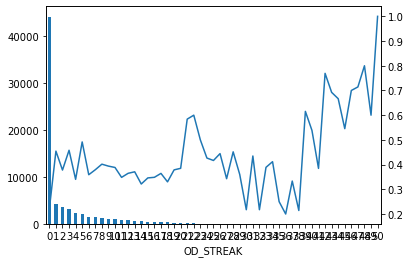

In [1679]:
ax = lods_df.groupby(['OD_STREAK']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['OD_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1680]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lods_df['ODS_BIN']=pd.cut(lods_df.OD_STREAK, bins=cut_bins, labels=cut_labels_4)

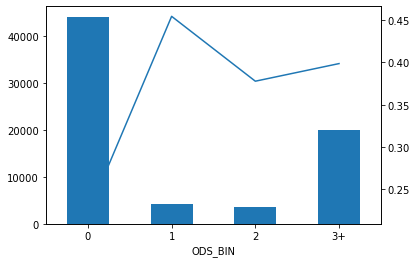

In [1681]:
ax = lods_df.groupby(['ODS_BIN']).AGMTNO.count().plot(kind='bar')
lods_df.groupby(['ODS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1682]:
OD_engineered_features_df = los_df.copy()

OD_engineered_features_df = pd.merge(OD_engineered_features_df, hb_df[['AGMTNO', 'HB_BIN', 'YEAR_MONTH']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

OD_engineered_features_df = pd.merge(OD_engineered_features_df, lods_df[['AGMTNO', 'YEAR_MONTH', 'ODS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#OD_engineered_features_df.fillna(0, inplace = True)


OD_engineered_features_df = OD_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'HB_BIN','OD_BIN','ODS_BIN']]

OD_engineered_features_df.shape


(71997, 5)

## MOVEMENT VARIBALES

In [1683]:
frame_df=Customer_Hist_df.copy()
frame_df['movement'] = None
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == 0)), 'movement'] = 'normalize'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET < frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'rollback'
frame_df.loc[((frame_df.OPEN_DPD_BKT_GRP > 0)  & (frame_df.CLOSING_BUCKET == frame_df.OPEN_DPD_BKT_GRP) & (frame_df.CLOSING_BUCKET > 0)), 'movement'] = 'stabilize'

movement = frame_df.groupby(['AGMTNO', 'YEAR_MONTH']).movement.value_counts().unstack().reset_index()
movement.sort_values(by = "YEAR_MONTH", ascending = True, inplace = True)
movement.fillna(0, inplace = True)

#### check for movement columns and add manually if missing 
if('rollback' not in movement.columns):
   movement['rollback'] = 0
   
if('normalize' not in movement.columns):
   movement['normalize'] = 0

if('stabilize' not in movement.columns):
   movement['stabilize']= 0
####

movement_merge = frame_df.merge(movement, how = "left", on = ['AGMTNO', 'YEAR_MONTH'])
movement_merge.sort_values(by = "YEAR_MONTH", inplace = True)

movement_rolling = movement_merge.groupby("AGMTNO")[['normalize', 'rollback', 'stabilize']].transform(lambda x : x.expanding().sum().shift(1))
movement_rolling = movement_rolling.rename(columns = {"normalize": "normalize_total", "rollback": "rollback_total", "stabilize": "stabilize_total"})
movement_rolling = pd.concat([movement_merge, movement_rolling], axis = 1)
movement_rolling = movement_rolling[['AGMTNO', 'YEAR_MONTH', 'normalize_total', 'rollback_total', 'stabilize_total','FLOW_FLAG']].fillna(0)

#movement_rolling .to_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv',index=False)
# # filtering for focus year month
# movement_rolling = movement_rolling.loc[movement_rolling.YEAR_MONTH == focus_year_month, :]


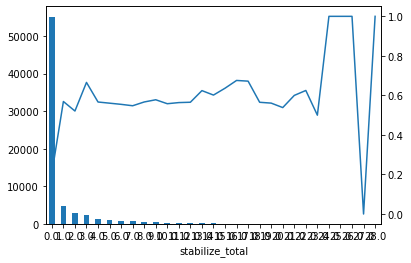

In [1684]:
ax = movement_rolling.groupby(['stabilize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['stabilize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1685]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
movement_rolling['STAB_BIN']=pd.cut(movement_rolling.stabilize_total, bins=cut_bins, labels=cut_labels_4)

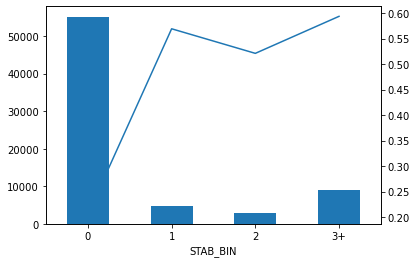

In [1686]:
ax = movement_rolling.groupby(['STAB_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['STAB_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


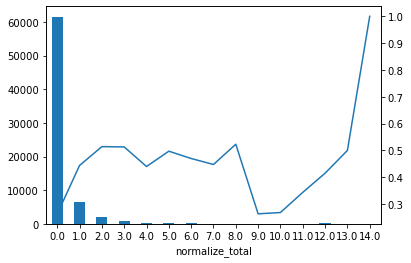

In [1687]:
ax = movement_rolling.groupby(['normalize_total']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['normalize_total']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1688]:
cut_labels_4 = ['NOT_NORM', 'NORM']
cut_bins = [-1, 0,100]
movement_rolling['NORM_BIN']=pd.cut(movement_rolling.normalize_total, bins=cut_bins, labels=cut_labels_4)

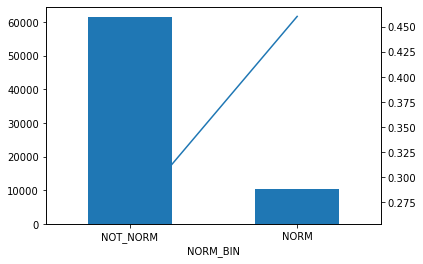

In [1689]:
ax = movement_rolling.groupby(['NORM_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['NORM_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1690]:
cut_labels_4 = ['NO', 'YES']
cut_bins = [-1, 0,100]
movement_rolling['RLBK_BIN']=pd.cut(movement_rolling.rollback_total, bins=cut_bins, labels=cut_labels_4)

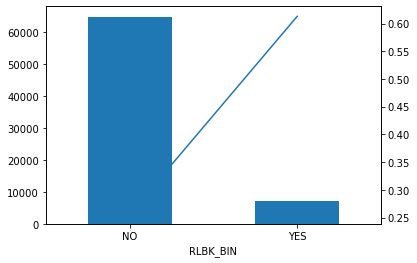

In [1691]:
ax = movement_rolling.groupby(['RLBK_BIN']).AGMTNO.count().plot(kind='bar')
movement_rolling.groupby(['RLBK_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1692]:
movement_rolling=movement_rolling[['AGMTNO', 'YEAR_MONTH', 'STAB_BIN', 'NORM_BIN','RLBK_BIN']]
movement_rolling.shape

(71997, 5)

## FLOW VARIABLES

In [1693]:
##### LAST MONTH FLOW
#frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
lmf_df = Customer_Hist_df[['AGMTNO', 'YEAR_MONTH', 'FLOW_FLAG']].sort_values(['AGMTNO', 'YEAR_MONTH'])
lmf_df_1 = lmf_df.copy()
lmf_df = lmf_df.groupby('AGMTNO').apply(lambda x: x.FLOW_FLAG.shift()).to_frame().reset_index().drop(columns=['level_1'])
lmf_df.columns = ['AGMTNO', 'LAST_MONTH_FLOW']
lmf_df.LAST_MONTH_FLOW.fillna(False, inplace = True)
lmf_df.LAST_MONTH_FLOW = lmf_df.LAST_MONTH_FLOW.fillna(0).astype(int)
lmf_df['YEAR_MONTH'] = lmf_df_1['YEAR_MONTH'].tolist()
lmf_df['FLOW_FLAG'] = lmf_df_1['FLOW_FLAG'].fillna(0).astype(int).tolist()

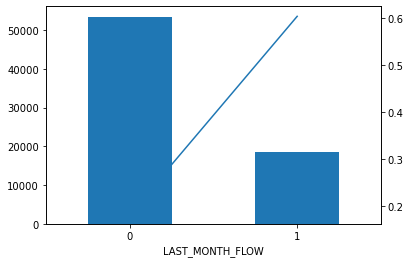

In [1694]:
ax = lmf_df.groupby(['LAST_MONTH_FLOW']).AGMTNO.count().plot(kind='bar')
lmf_df.groupby(['LAST_MONTH_FLOW']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1695]:

##### LAST 3 MONTH FLOW COUNT

l3mf_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
l3mf_df_1 = l3mf_df.copy()
l3mf_df = l3mf_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
l3mf_df = l3mf_df.groupby('AGMTNO')['LAST_MONTH_FLOW'].rolling(3, min_periods=1).sum().to_frame().reset_index().drop(['level_1'], axis=1)
l3mf_df.columns = ['AGMTNO', 'LAST_3MONTH_FLOW_COUNT']
l3mf_df['YEAR_MONTH'] = l3mf_df_1['YEAR_MONTH']
l3mf_df['FLOW_FLAG'] = l3mf_df_1['FLOW_FLAG'].tolist()


In [1696]:
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count())

LAST_3MONTH_FLOW_COUNT
0.00   0.14
1.00   0.31
2.00   0.66
3.00   0.75
dtype: float64

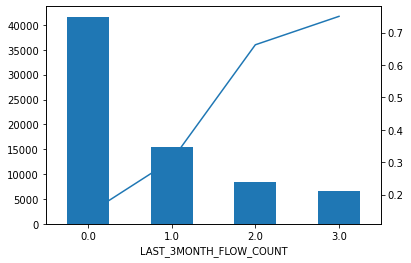

In [1697]:
ax = l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).AGMTNO.count().plot(kind='bar')
l3mf_df.groupby(['LAST_3MONTH_FLOW_COUNT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1698]:
#### LONGEST FLOW STREAK

lfs_df = lmf_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW','FLOW_FLAG']]
lfs_df_1 = lfs_df.copy()
lfs_df = lfs_df.sort_values(['AGMTNO', 'YEAR_MONTH'])
lfs_df = lfs_df.groupby('AGMTNO').apply(lambda y: y.LAST_MONTH_FLOW * (y.LAST_MONTH_FLOW.groupby((y.LAST_MONTH_FLOW != y.LAST_MONTH_FLOW.shift()).cumsum()).cumcount() + 1)).to_frame().reset_index().drop(['level_1'], axis=1)
lfs_df.columns = ['AGMTNO', 'LFS']
lfs_df['YEAR_MONTH'] = lfs_df_1['YEAR_MONTH']
lfs_df['LONGEST_FLOW_STREAK'] = lfs_df.groupby('AGMTNO')['LFS'].apply(lambda x : x.expanding().max()).reset_index(drop=True)
lfs_df = lfs_df[['AGMTNO', 'YEAR_MONTH', 'LONGEST_FLOW_STREAK']]
lfs_df['FLOW_FLAG'] = lfs_df_1['FLOW_FLAG']
# frame_df_1['YEAR_MONTH']=pd.to_datetime(frame_df_1.YEAR_MONTH)
# lfs_df = pd.merge(lfs_df, frame_df_1[['AGMTNO', 'YEAR_MONTH', 'MOB']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')


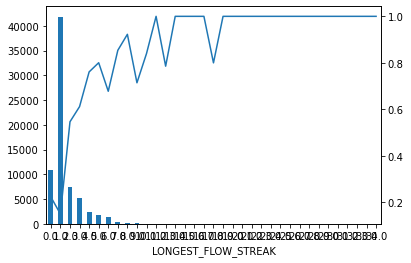

In [1699]:
ax = lfs_df.groupby(['LONGEST_FLOW_STREAK']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LONGEST_FLOW_STREAK']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [1700]:
cut_labels_4 = ['0', '1', '2', '3+']
cut_bins = [-1, 0, 1, 2,100]
lfs_df['LFS_BIN']=pd.cut(lfs_df.LONGEST_FLOW_STREAK, bins=cut_bins, labels=cut_labels_4)

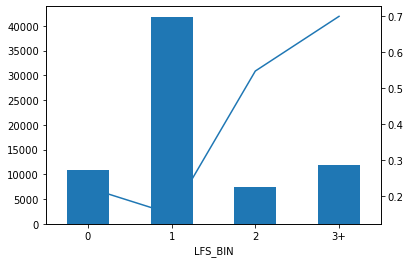

In [1701]:
ax = lfs_df.groupby(['LFS_BIN']).AGMTNO.count().plot(kind='bar')
lfs_df.groupby(['LFS_BIN']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [1702]:
## MERGING FLOW FEATURES

flow_engineered_features_df = l3mf_df

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lfs_df[['AGMTNO', 'YEAR_MONTH', 'LFS_BIN']], on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

flow_engineered_features_df = pd.merge(flow_engineered_features_df, lmf_df, on = ['AGMTNO', 'YEAR_MONTH'], how = 'inner')

#flow_engineered_features_df.fillna(0, inplace = True)

flow_engineered_features_df = flow_engineered_features_df[['AGMTNO', 'YEAR_MONTH', 'LAST_MONTH_FLOW', 'LAST_3MONTH_FLOW_COUNT', 'LFS_BIN']]

flow_engineered_features_df.shape


(71997, 5)

## DEMOGRAPHIC VARIABLES

In [1703]:
#Customer_details_df=pd.read_csv('D:\Collections\Adhoc\COVID_PL_CUST_PROFILE_DATA.csv')
Customer_details_df=Customer_Hist_df_OCT[Static_cols]
Customer_details_df.shape


(2451, 37)

In [1704]:

Customer_details_df.loc[Customer_details_df.GENDER=='M','GENDER']='MALE'
Customer_details_df.loc[Customer_details_df.GENDER=='F','GENDER']='FEMALE'
Customer_details_df.GENDER.fillna(Customer_details_df.GENDER.value_counts().index[0],inplace=True)
#Customer_details_df.GENDER.value_counts()

Customer_details_df.CIBIL_SCORE.fillna(-1.000, inplace = True)
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE=='LOW_RISK'),'CIBIL_SCORE'] = 750

Customer_details_df['CIBIL_CAT']=None
Customer_details_df['CIBIL_CAT']= np.where((Customer_details_df.CIBIL_SCORE<5),'NEW',np.where(((Customer_details_df.CIBIL_SCORE >=700)& (Customer_details_df.CIBIL_SCORE<=900)),'CREAMY',0))
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=5)& (Customer_details_df.CIBIL_SCORE<=400)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[((Customer_details_df.CIBIL_SCORE>=401)& (Customer_details_df.CIBIL_SCORE<700)),'CIBIL_CAT'] = 'MODERATE-RISKY'
Customer_details_df.loc[(Customer_details_df.CIBIL_SCORE==-1),'CIBIL_CAT'] = 'NEW'
Customer_details_df.loc[(Customer_details_df.CIBIL_CAT=="0"),'CIBIL_CAT'] = 'NEW'



Master_Cust_Profile = pd.read_csv('D:/Collections/RoF-UC/Master_Profile_Code.csv',encoding='cp1252')
# Master_Model_Code = pd.read_csv('D:/Collections/RoF-UC/Master_Model_Code.csv',encoding='cp1252')

Customer_details_df.CUSTOMER_PROFILE_CODE.fillna(Customer_details_df.CUSTOMER_PROFILE_CODE.value_counts().index[0],inplace=True)
Customer_details_df=Customer_details_df.merge(Master_Cust_Profile[['PROFILE_CODE','PROFILE_GROUP']],left_on='CUSTOMER_PROFILE_CODE'\
                                 ,right_on='PROFILE_CODE',how='left')
Customer_details_df.PROFILE_GROUP.fillna('Others',inplace=True)

# Customer_details_df=Customer_details_df.merge(Master_Model_Code[['MODEL_CODE','MODEL_YEAR','MODEL_SEGMENT']],on='MODEL_CODE',how='left')
# Customer_details_df.MODEL_SEGMENT.fillna(Customer_details_df.MODEL_SEGMENT.value_counts().index[0],inplace=True)


Customer_details_df['LTV_CAT']= np.where((Customer_details_df.LTV>80),'GT80','LT80')

### FOR CA ########################
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10,000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

Customer_details_df.DOWN_PAYMENT.fillna(Customer_details_df.DOWN_PAYMENT.mean(),inplace=True)
cut_labels_5 = ['<=4500', '4501-5500', '5501-6500','6501-7500','7501-10000','10000+']
cut_bins = [-1, 4500, 5500, 6500,7500,10000,1000000]
Customer_details_df['DOWN_PAYMENT_GRP']=pd.cut(Customer_details_df.DOWN_PAYMENT, bins=cut_bins, labels=cut_labels_5)

Customer_details_df.rename(columns={'AREA_DISPALY_NAME':'AREA_NAME','REGIONAL_GROUPING':'REGION'},inplace=True)
Customer_details_df.AREA_NAME.fillna(Customer_details_df.AREA_NAME.value_counts().index[0],inplace=True)

## EMI_CAT
# Customer_details_df['EMI_CAT']=None
# Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-2500'
# #Customer_details_df.loc[Customer_details_df.EMI>=1000,'EMI_CAT']= '1000-2500'
# Customer_details_df.loc[Customer_details_df.EMI>2500,'EMI_CAT']= '2500-5000'
# Customer_details_df.loc[Customer_details_df.EMI> 5000,'EMI_CAT']= 'GT5000'

############ FOR CA #######################

Customer_details_df['EMI_CAT']=None
Customer_details_df.loc[Customer_details_df.EMI>0,'EMI_CAT']= 'LT-5000'
Customer_details_df.loc[Customer_details_df.EMI>5000,'EMI_CAT']= '5001-7500'
Customer_details_df.loc[Customer_details_df.EMI> 7500,'EMI_CAT']= '7501-10000'
Customer_details_df.loc[Customer_details_df.EMI> 10000,'EMI_CAT']= '10,0001-12,500'
Customer_details_df.loc[Customer_details_df.EMI> 12500,'EMI_CAT']= 'GT12,500'

## Customer Profile 
a_p=['Finance related business','Hotel business related','Real estate / Construction related business','Rental Income earner'
    ,'Transport realted business','Pension / Husband income / parental income']
Customer_details_df['FINAL_PROFILE_GRP']=Customer_details_df.PROFILE_GROUP.tolist()
Customer_details_df.loc[Customer_details_df.PROFILE_GROUP.isin(a_p),'FINAL_PROFILE_GRP']='Others'
Customer_details_df.FINAL_PROFILE_GRP.value_counts(dropna=False)

### DIGITAL_SAVVY
#Customer_details_df.DIGITAL_SAVVY_FLAG.fillna(Customer_details_df.DIGITAL_SAVVY_FLAG.value_counts().index[0],inplace=True)

### ADV_EMI_FLAG
Customer_details_df.ADVANCE_EMI_COUNT.fillna(Customer_details_df.ADVANCE_EMI_COUNT.mean(),inplace=True)
Customer_details_df['ADV_EMI_FLAG']=np.where(Customer_details_df.ADVANCE_EMI_COUNT>0,'YES', 'NO')

## POS_TOBE_PAID
Customer_details_df['POS_TOBE_PAID_FINAL']=round((Customer_details_df.POS/Customer_details_df.LOAN_AMOUNT),2)

Customer_details_df.POS_TOBE_PAID_FINAL.fillna(Customer_details_df.POS_TOBE_PAID_FINAL.mean(),inplace=True)
Customer_details_df.loc[Customer_details_df.POS_TOBE_PAID_FINAL >1, 'POS_TOBE_PAID_FINAL']=1


# final_vars=[ 'AGMTNO','DIGITAL_SAVVY_FLAG', 'ROF_SEGMENT','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL'
#             ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df.FEB_COLLECTIONS_SEGMENTS.fillna(Customer_details_df.FEB_COLLECTIONS_SEGMENTS.value_counts().index[0],inplace=True)
final_vars=[ 'AGMTNO','ADV_EMI_FLAG', 'GENDER', 'POS_TOBE_PAID_FINAL','FEB_COLLECTIONS_SEGMENTS','NEW_COLLECTIONS_SEGMENTS'
            ,'CIBIL_CAT','PROFILE_CODE', 'PROFILE_GROUP', 'LTV_CAT', 'EMI_CAT','DOWN_PAYMENT_GRP', 'FINAL_PROFILE_GRP']

Customer_details_df[final_vars].isnull().sum()


Self employed with business premisis    945
Others                                  671
Salaried employee                       379
Agriculture related business            284
Self employed - professional            148
Caution Profile                          24
Name: FINAL_PROFILE_GRP, dtype: int64

AGMTNO                       0
ADV_EMI_FLAG                 0
GENDER                       0
POS_TOBE_PAID_FINAL          0
FEB_COLLECTIONS_SEGMENTS     0
NEW_COLLECTIONS_SEGMENTS    27
CIBIL_CAT                    0
PROFILE_CODE                 0
PROFILE_GROUP                0
LTV_CAT                      0
EMI_CAT                      0
DOWN_PAYMENT_GRP             0
FINAL_PROFILE_GRP            0
dtype: int64

## EDA on DEMO Variables

In [1705]:
Rest_cols=set(Customer_Hist_df.columns.to_list()) - set(Static_cols)
Rest_cols.add('AGMTNO')
Rest_cols= list(Rest_cols)
#Rest_cols

In [1707]:
Cust_Final_df=pd.DataFrame()
Cust_Final_df=pd.merge(Customer_Hist_df[Rest_cols],Customer_details_df,on='AGMTNO',how='inner')
Cust_Final_df.shape


(71997, 74)

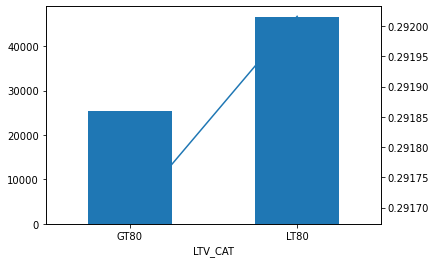

In [1708]:
## LTV
ax = Cust_Final_df.groupby(['LTV_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['LTV_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

In [1709]:
# ## ROF
# ax = Cust_Final_df.groupby(['ROF_SEGMENT']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['ROF_SEGMENT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

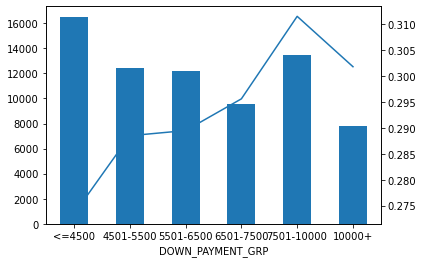

In [1710]:
## DOWN_PAYMENT_GRP
ax = Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['DOWN_PAYMENT_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

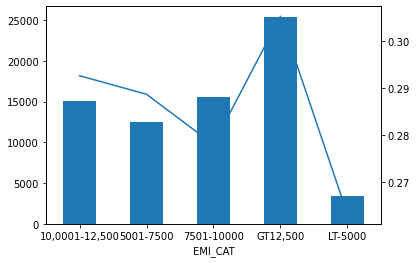

In [1711]:
## EMI_CAT

ax = Cust_Final_df.groupby(['EMI_CAT']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['EMI_CAT']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)

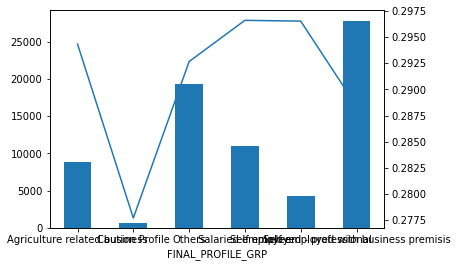

In [1712]:
ax = Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['FINAL_PROFILE_GRP']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


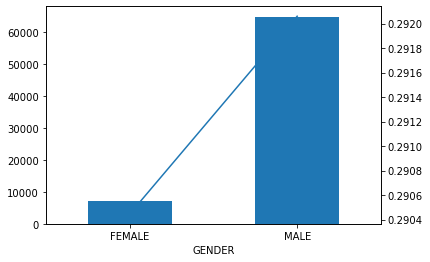

In [1713]:
### GENDER
ax = Cust_Final_df.groupby(['GENDER']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['GENDER']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1714]:
# ### DIGITAL_SAVVY
# ax = Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).AGMTNO.count().plot(kind='bar')
# Cust_Final_df.groupby(['DIGITAL_SAVVY_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


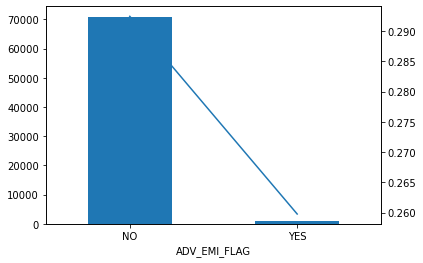

In [1715]:
### ADV_EMI_FLAG

ax = Cust_Final_df.groupby(['ADV_EMI_FLAG']).AGMTNO.count().plot(kind='bar')
Cust_Final_df.groupby(['ADV_EMI_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


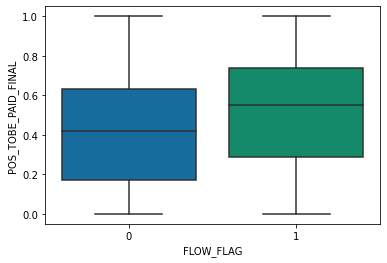

In [1716]:
## POS_TOBE_PAID
sns.boxplot(x='FLOW_FLAG',y='POS_TOBE_PAID_FINAL', 
                 data=Cust_Final_df,
                 palette="colorblind"
                 )

## FINAL DATA PREPARATION

In [1717]:
complete_df_OCT=Customer_details_df[final_vars].copy()
complete_df_OCT.shape

#bounce_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/bounce_engineered_features.csv')
#bounce_features['YEAR_MONTH'] = pd.to_datetime(bounce_features.YEAR_MONTH,format='%d/%m/%Y')
complete_df_OCT = complete_df_OCT.merge(bounce_engineered_features_df, on = ['AGMTNO'], how = "left")
#del bounce_features
print(complete_df_OCT.shape)

# flow_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/flow_engineered_features.csv')
# flow_features['YEAR_MONTH'] = pd.to_datetime(flow_features.YEAR_MONTH)
complete_df_OCT = complete_df_OCT.merge(flow_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
#del flow_features
print(complete_df_OCT.shape)


#OD_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/OD_engineered_features.csv')
#OD_features['YEAR_MONTH'] = pd.to_datetime(OD_features.YEAR_MONTH)
complete_df_OCT = complete_df_OCT.merge(OD_engineered_features_df, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_OCT.shape)

#movement_features= pd.read_csv('D:/Collections/RoF-UC/Predict_Month/movement_features.csv')
#movement_features['YEAR_MONTH'] = pd.to_datetime(movement_features.YEAR_MONTH)
complete_df_OCT = complete_df_OCT.merge(movement_rolling, on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
#del movement_features
complete_df_OCT = complete_df_OCT.merge(Customer_Hist_df[['AGMTNO', 'YEAR_MONTH','FLOW_FLAG']], on = ['AGMTNO', 'YEAR_MONTH'], how = "left")
print(complete_df_OCT.shape)


(2451, 13)

(71997, 17)
(71997, 20)
(71997, 23)
(71997, 27)


In [2177]:
## ADDING MORATORIUM FLAG
complete_df_OCT=complete_df_OCT.merge(MORAT_df,on='AGMTNO',how='left')
complete_df_OCT.MORAT_FLAG.fillna('NO_MORAT',inplace=True)
complete_df_OCT.loc[complete_df_OCT.MORAT_FLAG=='SuoMoto ,Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_OCT.loc[complete_df_OCT.MORAT_FLAG=='SuoMoto ','MORAT_FLAG']='SuoMoto'
complete_df_OCT.loc[complete_df_OCT.MORAT_FLAG=='Gen_Morat','MORAT_FLAG']='SuoMoto'
complete_df_OCT.MORAT_FLAG.value_counts(dropna=False)
complete_df_OCT.drop(columns={'MORAT_MONTH'},inplace=True)
complete_df_OCT.shape

SuoMoto     53750
NO_MORAT    18247
Name: MORAT_FLAG, dtype: int64

(71997, 28)

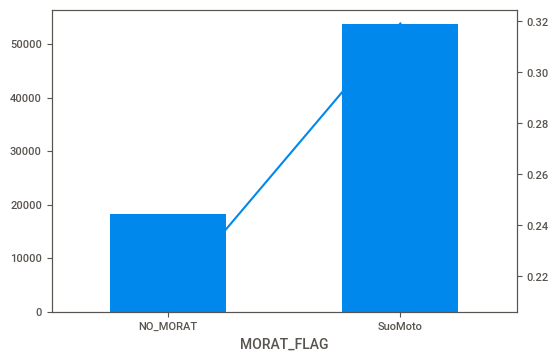

In [2178]:
ax = complete_df_OCT.groupby(['MORAT_FLAG']).AGMTNO.count().plot(kind='bar')
complete_df_OCT.groupby(['MORAT_FLAG']).apply(lambda x: x.FLOW_FLAG.sum()/x.FLOW_FLAG.count()).plot(kind='line',secondary_y = True, ax = ax)


In [1719]:
## MISISNG VALUE TREATMENT

complete_df_OCT.isna().sum()
complete_df_OCT.HB_BIN.fillna(complete_df_OCT.HB_BIN.value_counts().index[0],inplace=True)
complete_df_OCT.NEW_COLLECTIONS_SEGMENTS.fillna(complete_df_OCT.NEW_COLLECTIONS_SEGMENTS.value_counts().index[0],inplace=True)
complete_df_OCT.isna().values.sum()

AGMTNO                        0
ADV_EMI_FLAG                  0
GENDER                        0
POS_TOBE_PAID_FINAL           0
FEB_COLLECTIONS_SEGMENTS      0
NEW_COLLECTIONS_SEGMENTS    644
CIBIL_CAT                     0
PROFILE_CODE                  0
PROFILE_GROUP                 0
LTV_CAT                       0
EMI_CAT                       0
DOWN_PAYMENT_GRP              0
FINAL_PROFILE_GRP             0
YEAR_MONTH                    0
LAST_3MONTH_BOUNCE_COUNT      0
LONGEST_BOUNCE_STREAK         0
LAST_MONTH_BOUNCE             0
LAST_MONTH_FLOW               0
LAST_3MONTH_FLOW_COUNT        0
LFS_BIN                       0
HB_BIN                        0
OD_BIN                        0
ODS_BIN                       0
STAB_BIN                      0
NORM_BIN                      0
RLBK_BIN                      0
FLOW_FLAG                     0
dtype: int64

0

## Training on JUL-20 DATA and TESTING on AUG to OCT (BKT3) DATA

In [201]:

train_JUL=complete_df_JUL[complete_df_JUL.YEAR_MONTH == datetime.strptime('01/07/2020', '%d/%m/%Y')]
train_JUL.shape

#train=pd.concat([train_JUL,train_AUG,train_SEP],axis=0,ignore_index=True)
train=train_JUL.copy()
train.shape


X_train=train.drop(columns=['AGMTNO','YEAR_MONTH','FLOW_FLAG'])
X_train.shape
Y_train=train['FLOW_FLAG']
Y_train.shape

### Creating a Testing SET on SEP=20 for evaluation during Training time.

test_SEP=complete_df_SEP[complete_df_SEP.YEAR_MONTH==datetime.strptime('01/09/2020', '%d/%m/%Y')]
test_SEP.shape
X_test_SEP=test_SEP.drop(columns=['AGMTNO','YEAR_MONTH','FLOW_FLAG'])
X_test_SEP.shape
Y_test_SEP=test_SEP['FLOW_FLAG']
Y_test_SEP.shape

##  List of Catagorical Features in the Data
cat_f=complete_df_JUL.select_dtypes(exclude=['float','int']).columns.to_list()
cat_f.pop(cat_f.index('AGMTNO'))
cat_f.pop(cat_f.index('YEAR_MONTH'))



(36347, 28)

(41404, 28)

(54039, 28)

(131790, 28)

(131790, 25)

(131790,)

(5694, 28)

(5694, 25)

(5694,)

In [ ]:
### Hyperparameter tuning using GRID SEARCH

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier # Or CatBoostRegressor


parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [50,60,70,80,90, 100],
                   'class_weights':[[1,1],[1,2],[1,3],[1,5],[2,3],[2,5]]
                 }
CBC = CatBoostClassifier(custom_loss=['AUC'])
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(X_train, Y_train,cat_features=cat_f)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)



In [202]:
bestparams=Grid_CBC.best_params_
model_cb = CatBoostClassifier(**bestparams)
model_cb.fit(X_train, Y_train, plot=True, cat_features=cat_f, eval_set=(X_test, Y_test))


'AGMTNO'

'YEAR_MONTH'

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6820443	test: 0.6888142	best: 0.6888142 (0)	total: 545ms	remaining: 2m 43s
1:	learn: 0.6714969	test: 0.6842722	best: 0.6842722 (1)	total: 1s	remaining: 2m 29s
2:	learn: 0.6616112	test: 0.6802184	best: 0.6802184 (2)	total: 1.41s	remaining: 2m 19s
3:	learn: 0.6521523	test: 0.6763951	best: 0.6763951 (3)	total: 1.8s	remaining: 2m 13s
4:	learn: 0.6432722	test: 0.6726867	best: 0.6726867 (4)	total: 2.27s	remaining: 2m 14s
5:	learn: 0.6347773	test: 0.6691423	best: 0.6691423 (5)	total: 2.68s	remaining: 2m 11s
6:	learn: 0.6265467	test: 0.6657131	best: 0.6657131 (6)	total: 3.12s	remaining: 2m 10s
7:	learn: 0.6189057	test: 0.6623709	best: 0.6623709 (7)	total: 3.49s	remaining: 2m 7s
8:	learn: 0.6115474	test: 0.6592783	best: 0.6592783 (8)	total: 3.91s	remaining: 2m 6s
9:	learn: 0.6047178	test: 0.6562537	best: 0.6562537 (9)	total: 4.29s	remaining: 2m 4s
10:	learn: 0.5978469	test: 0.6533408	best: 0.6533408 (10)	total: 4.64s	remaining: 2m 2s
11:	learn: 0.5915748	test: 0.6506418	best: 0.6506

93:	learn: 0.4655876	test: 0.5845317	best: 0.5845317 (93)	total: 34.6s	remaining: 1m 15s
94:	learn: 0.4653504	test: 0.5845293	best: 0.5845293 (94)	total: 35s	remaining: 1m 15s
95:	learn: 0.4650003	test: 0.5841266	best: 0.5841266 (95)	total: 35.3s	remaining: 1m 15s
96:	learn: 0.4647165	test: 0.5841210	best: 0.5841210 (96)	total: 35.7s	remaining: 1m 14s
97:	learn: 0.4645215	test: 0.5839979	best: 0.5839979 (97)	total: 36s	remaining: 1m 14s
98:	learn: 0.4642046	test: 0.5837376	best: 0.5837376 (98)	total: 36.4s	remaining: 1m 13s
99:	learn: 0.4639523	test: 0.5837182	best: 0.5837182 (99)	total: 36.8s	remaining: 1m 13s
100:	learn: 0.4636375	test: 0.5838760	best: 0.5837182 (99)	total: 37.1s	remaining: 1m 13s
101:	learn: 0.4634223	test: 0.5837128	best: 0.5837128 (101)	total: 37.4s	remaining: 1m 12s
102:	learn: 0.4632411	test: 0.5832529	best: 0.5832529 (102)	total: 37.8s	remaining: 1m 12s
103:	learn: 0.4628950	test: 0.5829506	best: 0.5829506 (103)	total: 38.1s	remaining: 1m 11s
104:	learn: 0.4626

185:	learn: 0.4480496	test: 0.5758816	best: 0.5757274 (176)	total: 1m 5s	remaining: 40.4s
186:	learn: 0.4479645	test: 0.5760552	best: 0.5757274 (176)	total: 1m 6s	remaining: 40.1s
187:	learn: 0.4478432	test: 0.5759442	best: 0.5757274 (176)	total: 1m 6s	remaining: 39.7s
188:	learn: 0.4476628	test: 0.5758939	best: 0.5757274 (176)	total: 1m 6s	remaining: 39.3s
189:	learn: 0.4475841	test: 0.5757257	best: 0.5757257 (189)	total: 1m 7s	remaining: 39s
190:	learn: 0.4475022	test: 0.5756782	best: 0.5756782 (190)	total: 1m 7s	remaining: 38.6s
191:	learn: 0.4471700	test: 0.5756932	best: 0.5756782 (190)	total: 1m 7s	remaining: 38.2s
192:	learn: 0.4469413	test: 0.5756231	best: 0.5756231 (192)	total: 1m 8s	remaining: 37.8s
193:	learn: 0.4466937	test: 0.5755216	best: 0.5755216 (193)	total: 1m 8s	remaining: 37.5s
194:	learn: 0.4464652	test: 0.5754068	best: 0.5754068 (194)	total: 1m 8s	remaining: 37.1s
195:	learn: 0.4461812	test: 0.5752188	best: 0.5752188 (195)	total: 1m 9s	remaining: 36.7s
196:	learn: 

276:	learn: 0.4368715	test: 0.5787580	best: 0.5750323 (204)	total: 1m 36s	remaining: 7.98s
277:	learn: 0.4368054	test: 0.5787432	best: 0.5750323 (204)	total: 1m 36s	remaining: 7.64s
278:	learn: 0.4367573	test: 0.5789101	best: 0.5750323 (204)	total: 1m 36s	remaining: 7.29s
279:	learn: 0.4367409	test: 0.5789176	best: 0.5750323 (204)	total: 1m 37s	remaining: 6.95s
280:	learn: 0.4366487	test: 0.5791675	best: 0.5750323 (204)	total: 1m 37s	remaining: 6.59s
281:	learn: 0.4366342	test: 0.5791470	best: 0.5750323 (204)	total: 1m 37s	remaining: 6.25s
282:	learn: 0.4365577	test: 0.5791097	best: 0.5750323 (204)	total: 1m 38s	remaining: 5.9s
283:	learn: 0.4365073	test: 0.5791755	best: 0.5750323 (204)	total: 1m 38s	remaining: 5.55s
284:	learn: 0.4364318	test: 0.5791624	best: 0.5750323 (204)	total: 1m 38s	remaining: 5.2s
285:	learn: 0.4363707	test: 0.5793151	best: 0.5750323 (204)	total: 1m 39s	remaining: 4.86s
286:	learn: 0.4362048	test: 0.5793406	best: 0.5750323 (204)	total: 1m 39s	remaining: 4.51s
2

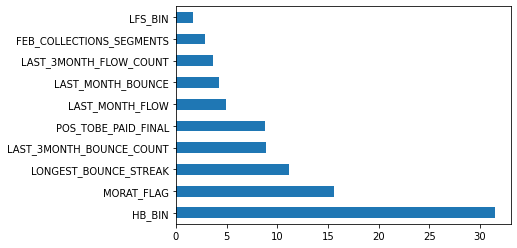

In [239]:
feat_imp_df=pd.DataFrame({'importance':model_cb.feature_importances_},index=X_train.columns)

#print(feat_imp_df.sort_values('importance',ascending=False))

feat_imp_df.importance.nlargest(10).sort_values(ascending=False).plot(kind='barh')

## Testing on AUG-20

In [213]:
# train=complete_df[(complete_df.YEAR_MONTH> datetime.strptime('01/03/2020', '%d/%m/%Y')) & \
#                   (complete_df.YEAR_MONTH< datetime.strptime('01/08/2020', '%d/%m/%Y'))]

test_AUG=complete_df_AUG[complete_df_AUG.YEAR_MONTH==datetime.strptime('01/08/2020', '%d/%m/%Y')]
#test_AUG=test_AUG[~test_AUG.AGMTNO.isin(test_score_df.AGMTNO.unique())]
test_AUG.shape
X_test_AUG=test_AUG.drop(columns=['AGMTNO','YEAR_MONTH','FLOW_FLAG'])
X_test_AUG.shape
Y_test_AUG=test_AUG['FLOW_FLAG']
Y_test_AUG.shape

(4485, 28)

(4485, 25)

(4485,)

In [214]:
y_pred_proba_AUG=model_cb.predict_proba(data=X_test_AUG)[:,1]
y_pred_proba_AUG
y_hat_test_AUG = np.where(y_pred_proba_AUG > 0.6, 1, 0)

array([0.708041, 0.768715, 0.596094, ..., 0.528580, 0.398401, 0.538569])

(array([35.000000, 37.000000, 328.000000, 219.000000, 962.000000,
        1259.000000, 555.000000, 553.000000, 414.000000, 123.000000]),
 array([0.241349, 0.302010, 0.362670, 0.423331, 0.483991, 0.544652,
        0.605313, 0.665973, 0.726634, 0.787294, 0.847955]),
 <a list of 10 Patch objects>)

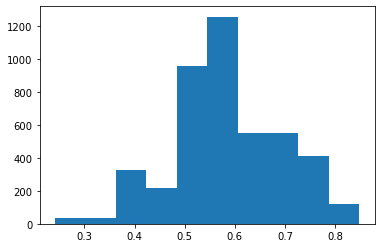

In [215]:
plt.hist(y_pred_proba_AUG)

## Checking Acuracy, Recall, Precision, F1-score, AUC and KS Stats for Model Performance

In [216]:
print(f'Accuracy Score: {accuracy_score(Y_test_AUG,y_hat_test_AUG)}')
print(f'Area Under Curve: {roc_auc_score(Y_test_AUG,y_hat_test_AUG)}') 
print(f'Recall score: {recall_score(Y_test_AUG,y_hat_test_AUG)}')
print(f'Precision score: {precision_score(Y_test_AUG,y_hat_test_AUG)}')
print(f'F1 score: {f1_score(Y_test_AUG,y_hat_test_AUG)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test_AUG,y_hat_test_AUG)}')


Accuracy Score: 0.711705685618729
Area Under Curve: 0.7949007142704609
Recall score: 0.9049360146252285
Precision score: 0.28513824884792627
F1 score: 0.43363994743758205
Confusion Matrix: 
[[2697 1241]
 [  52  495]]


In [217]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve-AUGUST')

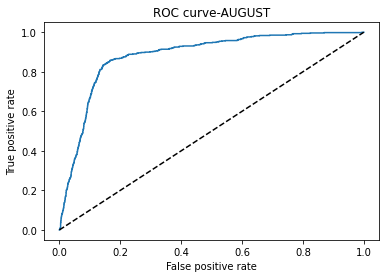

In [241]:
fpr, tpr, thresholds = roc_curve(Y_test_AUG, y_pred_proba_AUG)
# Here we store each of the three arrays in a separate variable. 
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve-AUGUST')
# We name the graph "ROC curve".

In [219]:
a=y_pred_proba_AUG
test_score_df_AUG=pd.DataFrame({'predict_prob':a+jitter(a), 'actual_output':Y_test_AUG})
test_score_df_AUG['predicted_output']=(test_score_df_AUG.predict_prob>0.6).astype(int)
test_score_df_AUG['Decile']=pd.qcut(test_score_df_AUG['predict_prob'],10,labels=False,duplicates='drop')
test_score_df_AUG['Decile']=test_score_df_AUG['Decile']+1

In [220]:
kstable=ks(data=test_score_df_AUG,target="actual_output", prob="predict_prob")
kstable.to_excel('D:\Collections\Adhoc\COVID_PL\CA_KS_AUG_DATA.xlsx',index=None)

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1           0.74      0.85     216        233     39.49%         5.92%   
2           0.69      0.74     200        248     36.56%         6.30%   
3           0.64      0.69      65        384     11.88%         9.75%   
4           0.60      0.64      18        430      3.29%        10.92%   
5           0.57      0.60      10        438      1.83%        11.12%   
6           0.55      0.57      15        434      2.74%        11.02%   
7           0.54      0.55      14        434      2.56%        11.02%   
8           0.51      0.54       5        444      0.91%        11.27%   
9           0.43      0.51       3        445      0.55%        11.30%   
10          0.24      0.43       1        448      0.18%        11.38%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             39.49

In [221]:
## Putting Threshold at 60% 
test_score_df_AUG['predicted_output']=(test_score_df_AUG.predict_prob>0.6).astype(int)
test_score_df_AUG.groupby('Decile').agg({'predicted_output':[sum,'count'],'actual_output':sum}).sort_values(by='Decile',ascending=True)

predicted_output       actual_output
                    sum count           sum
Decile                                     
1                     0   449             1
2                     0   448             3
3                     0   449             5
4                     0   448            14
5                     0   449            15
6                     0   448            10
7                   390   448            18
8                   449   449            65
9                   448   448           200
10                  449   449           216

In [231]:
profile_mapping = {                                      # This is for RISK_SEGMENT
        1:'LOW_RISK', 2:'LOW_RISK', 3 :'MEDIUM_RISK',4:'MEDIUM_RISK',5:'MEDIUM_RISK',
        6:'HIGH_RISK', 7:'HIGH_RISK',8 :'HIGH_RISK',9 : 'VERY_HIGH_RISK',10 :'VERY_HIGH_RISK'}

# profile_mapping = {                                      # This is for RISK_SEGMENT
#         1:'LOW_RISK', 2 :'LOW_RISK',3:'LOW_RISK',4:'MEDIUM_RISK', 5:'HIGH_RISK',6  : 'VERY_HIGH_RISK'}


test_score_df_AUG['ROF_SEG']= test_score_df_AUG['Decile'].replace(profile_mapping)

test_score_df_AUG.groupby('ROF_SEG').apply(lambda x: round((x.actual_output.sum()/x.actual_output.count())*100)).sort_values(ascending=True)

test_score_df_AUG.groupby('ROF_SEG').apply(lambda x: x.actual_output.count())


ROF_SEG
LOW_RISK          0.00
MEDIUM_RISK       3.00
HIGH_RISK         7.00
VERY_HIGH_RISK   46.00
dtype: float64

ROF_SEG
HIGH_RISK         1345
LOW_RISK           897
MEDIUM_RISK       1346
VERY_HIGH_RISK     897
dtype: int64

## TESTING on SEP-20 AGAIN

In [ ]:
test_SEP=complete_df_SEP[complete_df_SEP.YEAR_MONTH==datetime.strptime('01/09/2020', '%d/%m/%Y')]
test_SEP.shape
X_test_SEP=test_SEP.drop(columns=['AGMTNO','YEAR_MONTH','FLOW_FLAG'])
X_test_SEP.shape
Y_test_SEP=test_SEP['FLOW_FLAG']
Y_test_SEP.shape

In [203]:
#model_cb=model_cb_Orig.copy()
y_pred_proba=model_cb.predict_proba(data=X_test)[:,1]
y_pred_proba

y_hat_test = np.where(y_pred_proba > 0.6, 1, 0)
res = model_cb.predict(X_test)
print('error:',1-np.mean(res==np.ravel(Y_test)))

array([0.738283, 0.695053, 0.720681, ..., 0.714864, 0.745578, 0.523139])

error: 0.5512820512820513


(array([18.000000, 208.000000, 288.000000, 300.000000, 1157.000000,
        651.000000, 534.000000, 1141.000000, 1161.000000, 236.000000]),
 array([0.240901, 0.300384, 0.359868, 0.419351, 0.478835, 0.538318,
        0.597802, 0.657285, 0.716768, 0.776252, 0.835735]),
 <a list of 10 Patch objects>)

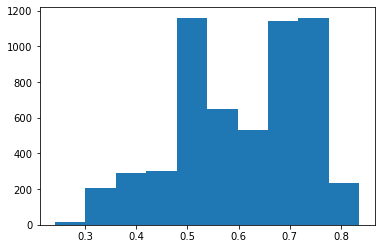

In [204]:
plt.hist(y_pred_proba)

## Checking Acuracy, Recall, Precision, F1-score, AUC and KS Stats for Model Performance

In [206]:
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score


In [207]:
print(f'Accuracy Score: {accuracy_score(Y_test,y_hat_test)}')
print(f'Area Under Curve: {roc_auc_score(Y_test,y_hat_test)}') 
print(f'Recall score: {recall_score(Y_test,y_hat_test)}')
print(f'Precision score: {precision_score(Y_test,y_hat_test)}')
print(f'F1 score: {f1_score(Y_test,y_hat_test)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test,y_hat_test)}')


Accuracy Score: 0.6246926589392343
Area Under Curve: 0.6696106539956621
Recall score: 0.7754728492983527
Precision score: 0.4180921052631579
F1 score: 0.5432784783073307
Confusion Matrix: 
[[2286 1769]
 [ 368 1271]]


In [208]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve-SEPTEMBER')

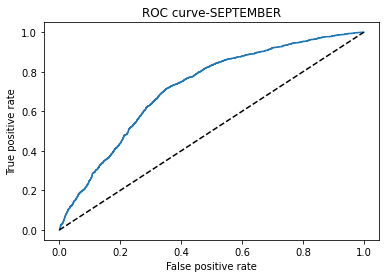

In [242]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
# Here we store each of the three arrays in a separate variable. 
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve-SEPTEMBER')
# We name the graph "ROC curve".

In [210]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

a=y_pred_proba
test_score_df=pd.DataFrame({'predict_prob':a+jitter(a), 'actual_output':Y_test})
#test_score_df=pd.DataFrame({'predict_prob':y_pred_proba, 'actual_output':Y_test})
test_score_df['predicted_output']=(test_score_df.predict_prob>0.55).astype(int)
test_score_df['predict_prob_rev']=(1-test_score_df.predict_prob)
test_score_df['Decile']=pd.qcut(test_score_df['predict_prob'],10,labels=False,duplicates='drop')
test_score_df['Decile']=test_score_df['Decile']+1

In [211]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [212]:
kstable=ks(data=test_score_df,target="actual_output", prob="predict_prob")
kstable.to_excel('D:\Collections\Adhoc\COVID_PL\CA_KS_SEP_DATA.xlsx',index=None)

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1           0.75      0.84     305        265     18.61%         6.54%   
2           0.73      0.75     253        316     15.44%         7.79%   
3           0.70      0.73     245        324     14.95%         7.99%   
4           0.68      0.70     245        325     14.95%         8.01%   
5           0.62      0.68     179        390     10.92%         9.62%   
6           0.57      0.62     142        427      8.66%        10.53%   
7           0.52      0.57      87        483      5.31%        11.91%   
8           0.50      0.52      77        492      4.70%        12.13%   
9           0.43      0.50      66        503      4.03%        12.40%   
10          0.24      0.43      40        530      2.44%        13.07%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             18.61

In [2148]:
## Putting Threshold at 55% 
test_score_df['predicted_output']=(test_score_df.predict_prob>0.6).astype(int)
test_score_df.groupby('Decile').agg({'predicted_output':[sum,'count'],'actual_output':sum}).sort_values(by='Decile',ascending=False)

predicted_output       actual_output
                    sum count           sum
Decile                                     
10                  570   570           287
9                   569   569           253
8                   569   569           264
7                   570   570           260
6                   569   569           159
5                   123   569           137
4                     0   570            98
3                     0   569            75
2                     0   569            61
1                     0   570            45

In [2150]:
profile_mapping = {                                      # This is for RISK_SEGMENT
        1:'LOW_RISK', 2:'LOW_RISK', 3 :'MEDIUM_RISK',4:'MEDIUM_RISK',5:'MEDIUM_RISK',
        6:'HIGH_RISK', 7:'HIGH_RISK',8 :'HIGH_RISK',9 : 'VERY_HIGH_RISK',10 :'VERY_HIGH_RISK'}

# profile_mapping = {                                      # This is for RISK_SEGMENT
#         1:'LOW_RISK', 2 :'MEDIUM_RISK',3:'MEDIUM_RISK',4:'HIGH_RISK', 5:'HIGH_RISK',6 :'HIGH_RISK',7 : 'VERY_HIGH_RISK'}


test_score_df['ROF_SEG']= test_score_df['Decile'].replace(profile_mapping)

test_score_df.groupby('ROF_SEG').apply(lambda x: round((x.actual_output.sum()/x.actual_output.count())*100)).sort_values(ascending=True)

test_score_df.groupby('ROF_SEG').apply(lambda x: x.actual_output.count())

ROF_SEG
LOW_RISK          9.00
MEDIUM_RISK      18.00
HIGH_RISK        40.00
VERY_HIGH_RISK   47.00
dtype: float64

ROF_SEG
HIGH_RISK         1708
LOW_RISK          1139
MEDIUM_RISK       1708
VERY_HIGH_RISK    1139
dtype: int64

## Testing on OCT-20

In [2179]:
# train=complete_df[(complete_df.YEAR_MONTH> datetime.strptime('01/03/2020', '%d/%m/%Y')) & \
#                   (complete_df.YEAR_MONTH< datetime.strptime('01/08/2020', '%d/%m/%Y'))]

test_OCT=complete_df_OCT[complete_df_OCT.YEAR_MONTH==datetime.strptime('01/10/2020', '%d/%m/%Y')]
#test_OCT=test_OCT[~test_OCT.AGMTNO.isin(test_score_df.AGMTNO.unique())]
test_OCT.shape
X_test_OCT=test_OCT.drop(columns=['AGMTNO','YEAR_MONTH','FLOW_FLAG'])
X_test_OCT.shape
Y_test_OCT=test_OCT['FLOW_FLAG']
Y_test_OCT.shape

(2451, 28)

(2451, 25)

(2451,)

In [2180]:
y_pred_proba_OCT=model_cb.predict_proba(data=X_test_OCT)[:,1]
y_pred_proba_OCT
y_hat_test_OCT = np.where(y_pred_proba_OCT > 0.6, 1, 0)

array([0.657770, 0.693577, 0.656499, ..., 0.724238, 0.669719, 0.614279])

(array([17.000000, 34.000000, 347.000000, 240.000000, 1011.000000,
        940.000000, 587.000000, 1180.000000, 1202.000000, 136.000000]),
 array([0.232465, 0.291822, 0.351179, 0.410536, 0.469893, 0.529250,
        0.588607, 0.647964, 0.707321, 0.766678, 0.826035]),
 <a list of 10 Patch objects>)

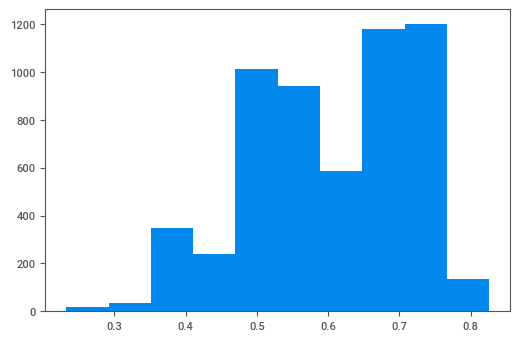

In [2181]:
plt.hist(y_pred_proba)

## Checking Acuracy, Recall, Precision, F1-score, AUC and KS Stats for Model Performance

In [2182]:
print(f'Accuracy Score: {accuracy_score(Y_test_OCT,y_hat_test_OCT)}')
print(f'Area Under Curve: {roc_auc_score(Y_test_OCT,y_hat_test_OCT)}') 
print(f'Recall score: {recall_score(Y_test_OCT,y_hat_test_OCT)}')
print(f'Precision score: {precision_score(Y_test_OCT,y_hat_test_OCT)}')
print(f'F1 score: {f1_score(Y_test_OCT,y_hat_test_OCT)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test_OCT,y_hat_test_OCT)}')


Accuracy Score: 0.7123623011015912
Area Under Curve: 0.606267864434463
Recall score: 0.7125357288689261
Precision score: 0.9994272623138603
F1 score: 0.831942789034565
Confusion Matrix: 
[[   1    1]
 [ 704 1745]]


In [2183]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve')

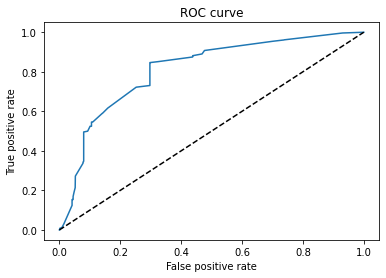

In [1110]:
fpr, tpr, thresholds = roc_curve(Y_test_OCT, y_pred_proba_OCT)
# Here we store each of the three arrays in a OCTarate variable. 
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [2184]:
a=y_pred_proba_OCT
test_score_df_OCT=pd.DataFrame({'predict_prob':a+jitter(a), 'actual_output':Y_test_OCT})
test_score_df_OCT['predicted_output']=(test_score_df_OCT.predict_prob>0.5).astype(int)
test_score_df_OCT['Decile']=pd.qcut(test_score_df_OCT['predict_prob'],10,labels=False,duplicates='drop')
test_score_df_OCT['Decile']=test_score_df_OCT['Decile']+1

In [2185]:
kstable=ks(data=test_score_df_OCT,target="actual_output", prob="predict_prob")
kstable.to_excel('D:\Collections\Adhoc\COVID_PL\CA_KS_OCT_DATA.xlsx',index=None)

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1           0.74      0.81     245          0     10.00%         0.00%   
2           0.71      0.74     245          0     10.00%         0.00%   
3           0.70      0.71     245          0     10.00%         0.00%   
4           0.68      0.70     245          0     10.00%         0.00%   
5           0.67      0.68     244          1      9.96%        50.00%   
6           0.64      0.67     245          0     10.00%         0.00%   
7           0.61      0.64     245          0     10.00%         0.00%   
8           0.52      0.61     245          0     10.00%         0.00%   
9           0.43      0.52     245          0     10.00%         0.00%   
10          0.23      0.43     245          1     10.00%        50.00%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             10.00

In [2186]:
## Putting Threshold at 6% 
test_score_df_OCT['predicted_output']=(test_score_df_OCT.predict_prob>0.6).astype(int)
test_score_df_OCT.groupby('Decile').agg({'predicted_output':[sum,'count'],'actual_output':sum}).sort_values(by='Decile',ascending=True)

predicted_output       actual_output
                    sum count           sum
Decile                                     
1                     0   246           245
2                     0   245           245
3                    31   245           245
4                   245   245           245
5                   245   245           245
6                   245   245           244
7                   245   245           245
8                   245   245           245
9                   245   245           245
10                  245   245           245

In [2187]:
# profile_mapping = {                                      # This is for RISK_SEGMENT
#         1:'LOW_RISK', 2:'LOW_RISK', 3 :'MEDIUM_RISK',4:'MEDIUM_RISK',5:'MEDIUM_RISK',
#         6:'HIGH_RISK', 7:'HIGH_RISK',8 :'HIGH_RISK',9 : 'VERY_HIGH_RISK',10 :'VERY_HIGH_RISK'}

profile_mapping = {                                      # This is for RISK_SEGMENT
        1:'LOW_RISK', 2:'LOW_RISK', 3 :'LOW_RISK',4:'HIGH_RISK',5:'HIGH_RISK',
        6:'HIGH_RISK', 7:'HIGH_RISK',8 :'HIGH_RISK',9 : 'HIGH_RISK',10 :'HIGH_RISK'}

test_score_df_OCT['ROF_SEG']= test_score_df_OCT['Decile'].replace(profile_mapping)

test_score_df_OCT.groupby('ROF_SEG').apply(lambda x: round((x.actual_output.sum()/x.actual_output.count())*100)).sort_values(ascending=True)

test_score_df_OCT.groupby('ROF_SEG').apply(lambda x: x.actual_output.count())

ROF_SEG
HIGH_RISK   100.00
LOW_RISK    100.00
dtype: float64

ROF_SEG
HIGH_RISK    1715
LOW_RISK      736
dtype: int64